# Imports and setup

In [98]:
# Basic
import numpy as np
import scipy
import scipy.stats
import os
import itertools
import warnings
import sys
from copy import deepcopy

# Data Loading
import cmlreaders as cml #Penn Computational Memory Lab's library of data loading functions

# Data Handling
import os
from os import listdir as ld
import os.path as op
from os.path import join, exists as ex
import time
import datetime

# Data Analysis
import pandas as pd
import xarray as xr

# EEG & Signal Processing
import ptsa
from ptsa.data.readers import BaseEventReader, EEGReader, CMLEventReader, TalReader
from ptsa.data.filters import MonopolarToBipolarMapper, MorletWaveletFilter
from ptsa.data.timeseries import TimeSeries

# Data Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Parallelization
import cmldask.CMLDask as da
from cmldask.CMLDask import new_dask_client_slurm as cl
from cluster import wait, get_exceptions_quiet as get_ex
import cmldask

# Custom
from cstat import * #circular statistics
from misc import * #helper functions for loading and saving data, and for other purposes
from matrix_operations import * #matrix operations

from helper import *

%load_ext autoreload

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

beh_to_event_windows = {'en': [250-1000, 1250+1000],
                     'en_all': [250-1000, 1250+1000],
                     'rm': [-1000, 0],
                     'ri': [-1000, 0]}

beh_to_epochs = {'en': np.arange(250, 1250, 200),
              'en_all': np.arange(250, 1250, 200),
              'rm': np.arange(-1000, 0, 200),
              'ri': np.arange(-1000, 0, 200)}


from helper import root_dir, USERNAME as user
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

from functools import partial
cluster_log_dir = 'cluster'
cl = partial(cl, log_directory=cluster_log_dir)
if not os.path.exists(cluster_log_dir):
    os.mkdir(cluster_log_dir)

font_dirs = ['fonts']


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Unit tests

## Sampling rate

In [487]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [1815]:
for iSess, rSess in sess_list_df.iterrows(): # Iterate through each session row in the session list DataFrame
    
    try:
        reader = cml.CMLReader(*iSess) # Create CMLReader object for this session row
        sources = reader.load('sources') # Load sources file from CMLReaders
        sources_sr = sources['sample_rate'] # Get the sampling rate value contained within the sources file
        if sources_sr != rSess['sr']:
            message = f'{iSess}: Sampling rate is {sources_sr} in the sources file but {rSess["sr"]} in the DataFrame.'
            if ((np.char.endswith(sources['path'], 'params.txt') and rSess['eeg_data_source'] == 'cmlreaders') | (np.char.endswith(sources['path'], 'sources.json') and rSess['eeg_data_source'] == 'ptsa')):
                message += ' However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.'
            print(message)
    except FileNotFoundError:
        message = f'{iSess}: Sources file is not available. Sampling rate is {rSess["sr"]} in the DataFrame.'
        print(message)

('R1137E', 'FR1', 0, 0, 0): Sampling rate is 500 in the sources file but 499.71 in the DataFrame. However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.
('TJ029', 'pyFR', 0, 0, 0): Sampling rate is 2000.0 in the sources file but 1000.0 in the DataFrame. However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.
('TJ029', 'pyFR', 1, 0, 0): Sampling rate is 2000.0 in the sources file but 1000.0 in the DataFrame. However, the mismatch is due to a resampling of the data between the ptsa readers and CMLReaders.
('TJ053', 'pyFR', 1, 0, 2): Sources file is not available. Sampling rate is 1000.0 in the DataFrame.
('TJ053', 'pyFR', 0, 0, 3): Sources file is not available. Sampling rate is 2000.0 in the DataFrame.
('TJ062', 'pyFR', 0, 0, 2): Sampling rate is 1000.0 in the sources file but 2000.0 in the DataFrame.
('TJ062', 'pyFR', 1, 0, 2): Sampling rate is 1000.0 in the sources file but 2000.0 in the DataFrame.
('

cmlreaders loads incorrect source files (the source files for these subjects' montage 0) for the following:
- ('TJ062', 'pyFR', 0, 0, 2)
- ('TJ062', 'pyFR', 1, 0, 2)
- ('TJ069', 'pyFR', 0, 0, 1)
- ('TJ069', 'pyFR', 1, 0, 1)

Therefore, this sampling rate check has been passed.

## EEG selection, buffering, resampling, and filtering, and phase computation

### EEG selection

In [106]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [54]:
checked_event_count = 1 # Number of randomly selected events to be checked for each behavioral contrast
checked_pair_count = 1 # Number of randomly selected electrode pairs to be checked for each event
rtol = 1e-5
atol = 1e-8
for iSess, (_, rSess) in enumerate(sess_list_df.iterrows()): # Iterate through all the sessions in the session list DataFrame
    
    np.random.seed(iSess) # Set the random seed
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']] # Set dfrow, or session label, from session list DataFrame
    sub, exp, sess, loc, mon = dfrow
    mon_ = '' if mon==0 else f'_{mon}'
    data_source = rSess['eeg_data_source'] # Get data source (cmlreaders or ptsa) from
    pairs = get_pairs(dfrow) # Get the pairs for this session
    
    missing_channels = []
    if tuple(dfrow) in [('R1394E', 'FR1', 0, 0, 0)]:
        missing_channels = ['3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']

    if tuple(dfrow) in [('R1394E', 'FR1', 1, 1, 1),
                        ('R1394E', 'catFR1', 1, 1, 1), 
                        ('R1394E', 'catFR1', 2, 1, 1)]:
        missing_channels = ['35Ld2-35Ld3', '35Ld4-35Ld5', '35Ld6-35Ld7', '35Ld8-35Ld9', '3Ld10-3Ld11', '3Ld12-3Ld13', '3Ld14-3Ld1']

    if tuple(dfrow) in  [('R1354E', 'FR1', 0, 0, 0),
                         ('R1354E', 'FR1', 1, 0, 0),
                         ('R1354E', 'catFR1', 0, 0, 0),
                         ('R1354E', 'catFR1', 1, 0, 0),
                         ('R1354E', 'catFR1', 2, 0, 0),
                         ('R1354E', 'catFR1', 3, 0, 0)]:
        missing_channels = ['5Ldm1-5Ldm2', '5Ldm2-5Ldm3', '5Ldm3-5Ldm4', '5Ldm4-5Ldm5', '5Ldm5-5Ldm6', '5Ldm6-5Ldm7', '5Ldm7-5Ldm8', '5Ldm8-5Ldm9', '5Ldm9-5Ldm1', '25Ldm1-25Ldm2', '25Ldm2-25Ldm3', '25Ldm3-25Ldm4', '25Ldm4-25Ldm5', '25Ldm5-25Ldm6', '25Ldm6-25Ldm7', '25Ldm7-25Ldm8', '25Ldm8-25Ldm9', '25Ldm9-25Ldm1']
        
    pairs = pairs.query('label not in @missing_channels')
    pairs_sel_idxs = np.random.choice(np.arange(len(pairs)), size=checked_pair_count)
    pairs_sel = pairs.iloc[pairs_sel_idxs]
    
    for beh in ['en', 'rm']:
        
        events = load_events(dfrow, beh).sort_values(['mstime', 'eegoffset'])
        event_sel_idxs = np.random.choice(np.arange(len(events)), size=checked_event_count)
        events_sel = events.iloc[event_sel_idxs]
        
        saved_eeg_path = os.path.join(root_dir, beh, 'eeg', 'main_eeg', f'{ftag(dfrow)}_raw_eeg.npy') # Set the file path for the EEG snippet that was saved out during the run of the analyses
        saved_eeg = npl(saved_eeg_path) # Load the EEG snippet that was saved out during the run of the analyses into memory
        if data_source == 'ptsa': 
            ptsa_eeg = get_ptsa_eeg(dfrow, events, 0, 1000)
            gain = float(ptsa_eeg.gain)
            saved_eeg /= gain
        
        saved_eeg_sel = saved_eeg[..., (saved_eeg.shape[-1]//3):(2*saved_eeg.shape[-1]//3)] if beh == 'en' else saved_eeg
        sr = get_sr(dfrow)
        assert sr-2 <= saved_eeg_sel.shape[-1] <= sr+2, f'{tuple(dfrow)}: Sample rate is {sr} but shape of saved_eeg_sel is {saved_eeg_sel.shape}'
                                 
        for iEvent, (_, rEvent) in zip(event_sel_idxs, events_sel.iterrows()):
            
            eegfile, eegoffset = rEvent[['eegfile', 'eegoffset']] # Get EEG file path and eegoffset value
            if data_source == 'cmlreaders': # If the EEG data source is cmlreaders, we are going to load up the EEG file from /protocols/r1/subjects
                
                raw_eeg_dir = os.path.join('/protocols/r1/subjects', sub, 'experiments', exp, 'sessions', str(sess), 'ephys/current_processed/noreref')
            elif data_source == 'ptsa': 
                raw_eeg_dir = os.path.join('/data/eeg', f'{sub}{mon_}', 'eeg.noreref')
            
            for iPair in pairs_sel_idxs:
                
                pair = pairs.iloc[iPair]
                contact_1, contact_2 = pair[['contact_1', 'contact_2']]
                
                if np.char.endswith(eegfile, '.h5'):
                    fname= os.path.join(raw_eeg_dir, eegfile)
                    f = h5py.File(fname,'r')
                    data = np.empty_like(f['timeseries'])
                    f['timeseries'].read_direct(data)
                    ch0_labels = np.empty_like(f['bipolar_info']['ch0_label'])
                    f['bipolar_info']['ch0_label'].read_direct(ch0_labels)
                    ch1_labels = np.empty_like(f['bipolar_info']['ch1_label'])
                    f['bipolar_info']['ch1_label'].read_direct(ch1_labels)
                    f.close()
                    assert len(ch0_labels) == len(ch1_labels)
                    labels = [(int(ch0_labels[i]), int(ch1_labels[i])) for i in np.arange(len(ch0_labels))]
                    iChannel = None
                    for i in range(len(ch0_labels)):
                        if (contact_1, contact_2) == labels[i]:
                            iChannel = i
                    if iChannel is None:
                        for i in range(len(ch0_labels)):
                            if (contact_2, contact_1) == labels[i]:
                                iChannel = i
                    bp_eeg = data[:, iChannel]
                
                else:
                    contact_1_eeg_trace_path = os.path.join(raw_eeg_dir, f'{eegfile}.{str(contact_1).zfill(3)}')
                    contact_2_eeg_trace_path = os.path.join(raw_eeg_dir, f'{eegfile}.{str(contact_2).zfill(3)}')
                    contact_1_eeg = np.memmap(contact_1_eeg_trace_path, dtype='int16')
                    contact_2_eeg = np.memmap(contact_2_eeg_trace_path, dtype='int16')
                    bp_eeg = np.subtract(contact_1_eeg, contact_2_eeg)
                    
                if beh == 'en':
                    raw_eeg_check = False
                    for margin_of_error in [-2, -1, 0, 1, 2]:
                        left_edge = eegoffset + int((250/1000)*sr) + margin_of_error
                        right_edge = left_edge + saved_eeg_sel.shape[-1]
                        bp_eeg_sel = bp_eeg[left_edge:right_edge]
                        for sign in [-1, 1]:
                            if np.allclose(sign*bp_eeg_sel, saved_eeg_sel[iEvent, iPair, :], rtol=rtol, atol=atol):
                                raw_eeg_check = True
                                break
                    assert raw_eeg_check, f'{tuple(dfrow)}, event {iEvent}, item {rEvent["item_name"]}, pair {iPair}, {beh}: failed. sr: {sr}, saved_eeg_sel shape: {saved_eeg_sel.shape}.\
                                            contacts: {contact_1}, {contact_2}.\
                                            contact paths: {contact_1_eeg_trace_path}, {contact_2_eeg_trace_path},\
                                            {bp_eeg_sel},\
                                            {saved_eeg_sel[iEvent, iPair, :]}' 
                        
                elif beh == 'rm':
                    raw_eeg_check = False
                    left_edge = eegoffset - saved_eeg_sel.shape[-1]
                    right_edge = eegoffset
                    bp_eeg_sel = bp_eeg[left_edge:right_edge]
                    for sign in [-1, 1]:
                        if np.allclose(sign*bp_eeg_sel, saved_eeg_sel[iEvent, iPair, :], rtol=rtol, atol=atol):
                            raw_eeg_check = True
                            break
                    assert raw_eeg_check, f'{tuple(dfrow)}, event {iEvent}, pair {iPair}, {beh}: failed.' 
        
        print(f'{tuple(dfrow)}, {beh}: check passed.')

('R1001P', 'FR1', 0, 0, 0), en: check passed.
('R1001P', 'FR1', 0, 0, 0), rm: check passed.
('R1001P', 'FR1', 1, 0, 0), en: check passed.
('R1001P', 'FR1', 1, 0, 0), rm: check passed.
('R1002P', 'FR1', 0, 0, 0), en: check passed.
('R1002P', 'FR1', 0, 0, 0), rm: check passed.
('R1002P', 'FR1', 1, 0, 0), en: check passed.
('R1002P', 'FR1', 1, 0, 0), rm: check passed.
('R1003P', 'FR1', 0, 0, 0), en: check passed.
('R1003P', 'FR1', 0, 0, 0), rm: check passed.
('R1003P', 'FR1', 1, 0, 0), en: check passed.
('R1003P', 'FR1', 1, 0, 0), rm: check passed.
('R1006P', 'FR1', 0, 0, 0), en: check passed.
('R1006P', 'FR1', 0, 0, 0), rm: check passed.
('R1006P', 'FR1', 1, 0, 0), en: check passed.
('R1006P', 'FR1', 1, 0, 0), rm: check passed.
('R1010J', 'FR1', 0, 0, 0), en: check passed.
('R1010J', 'FR1', 0, 0, 0), rm: check passed.
('R1010J', 'FR1', 1, 0, 0), en: check passed.
('R1010J', 'FR1', 1, 0, 0), rm: check passed.
('R1013E', 'catFR1', 0, 0, 1), en: check passed.
('R1013E', 'catFR1', 0, 0, 1), 

### Mirrored buffering

In [1049]:
sess_idx = 0 # Set session index
dfrow = sess_list_df.iloc[sess_idx] # Set dfrow, or session label, from session list DataFrame
sr = int(dfrow['sr']) # Get sampling rate from session list DataFrame
beh = 'rm' # Set behavioral contrast variable beh to retrieval/silence
events = load_events(dfrow, beh) # Load events for the desired session and behavioral contrast 
eeg = get_eeg(dfrow, events, -1000, 0) # Get raw EEG from dataset readers for this set of events for -1000 ms to 0 ms before the event
buffer_length = 1000 # Set buffer length (in ms) -- note that this is different from the buffer_length variable of the clip_buffer function, for which buffer_length is the number of array entries / timepoints
buffered_eeg = mirror_buffer(eeg, buffer_length)

In [1060]:
rtol = 1e-5 # Set relative tolerance parameter for np.allclose
atol = 1e-8 # Set absolute tolerance parameter for np.allclose
# Note that the below checks assume that 
assert np.allclose(buffered_eeg.data[..., sr:(2*sr)], eeg.data, rtol=rtol, atol=atol) # Check that the middle third of the buffered EEG is identical to the original raw EEG
assert np.allclose(buffered_eeg.data[..., 0:sr], np.flip(eeg.data, axis=-1), rtol=rtol, atol=atol) # Check that the beginning third of the buffe
assert np.allclose(buffered_eeg.data[..., (2*sr):], np.flip(eeg.data, axis=-1), rtol=rtol, atol=atol)
assert np.allclose(buffered_eeg.data[..., :sr], buffered_eeg.data[..., (2*sr):], rtol=rtol, atol=atol)
print('Checks passed.')

Checks passed


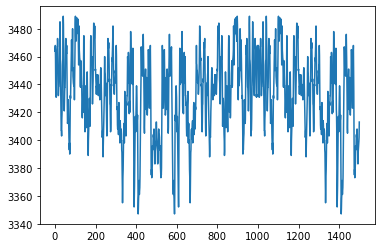

In [1044]:
iEvent = 0
iChannel = 10
buffered_eeg_sel = buffered_eeg.isel(event = iEvent, channel = iChannel).data # Select the buffered EEG signal for a particular event and channel
plt.plot(np.arange(len(buffered_eeg_sel)), buffered_eeg_sel)

### Notch filtering

In [1950]:
dfrow = sess_list_df.iloc[75]
print(tuple(dfrow[['sub', 'exp', 'sess', 'loc', 'mon']]))
beh = 'en'
events = load_events(dfrow, beh)
eeg = get_eeg(dfrow, events, 250, 1250)
eeg = eeg.resampled(250)
filtered_eeg = notch_filter(eeg, dfrow['sub'])

('R1066P', 'FR1', 2, 0, 0)


In [1952]:
from mne import time_frequency
sr = 250
psds, freqs = time_frequency.psd_array_welch(eeg.data, sfreq=sr, fmin=3, fmax=120, n_fft=128)  #the output is size (events x channels x freqs)
filtered_psds, filtered_freqs = time_frequency.psd_array_welch(filtered_eeg.data, sfreq=sr, fmin=3, fmax=120, n_fft=128)  #the output is size (events x channels x freqs)

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


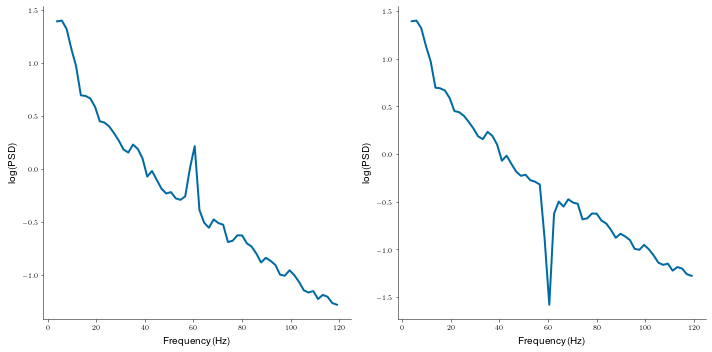

In [1956]:
log_psds = np.log10(psds)
log_filtered_psds = np.log10(filtered_psds)

np.random.seed(202410)
iCh=np.random.choice(eeg.shape[1])
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plt.plot(freqs, np.mean(log_psds[:, iCh, :], 0), linewidth=2)
plt.ylabel('log(PSD)', fontsize=10)
plt.xlabel('Frequency (Hz)', fontsize=10);

ax = plt.subplot(122)
plt.plot(filtered_freqs, np.mean(log_filtered_psds[:, iCh, :], 0), linewidth=2)
plt.ylabel('log(PSD)', fontsize=10)
plt.xlabel('Frequency (Hz)', fontsize=10);

plt.tight_layout()

### Phase computation

In [495]:
dfrow = sess_list_df.iloc[0]
beh = 'en'
events = load_events(dfrow, beh)
freqs = np.arange(3, 9)

In [590]:
def test_phase_computation(dfrow, beh):
        
        events = load_events(dfrow, beh)
        pairs = get_pairs(dfrow)
        phase, mask, sr = process_phase(dfrow, events, freqs)
        assert phase.shape[0:3] == (len(events), len(pairs), 6), f'{tuple(dfrow)}: failed. Phase shape: {phase.shape}.'
        assert 249 <= phase.shape[-1] <= 251, f'{tuple(dfrow)}: failed. Phase shape: {phase.shape}.'
        assert np.all(np.isfinite(phase)), f'{tuple(dfrow)}: failed'
        assert sr == phase.samplerate == 250, f'{tuple(dfrow)}: failed. Sample rate: {sr}.'
        
        phase = phase.data
        checks_passed = np.empty(phase.shape[0:3])
        for iEvent in np.arange(phase.shape[0]):
            for iChannel in np.arange(phase.shape[1]):
                for iFreq in np.arange(phase.shape[2]):
                    phase_sel = phase[iEvent, iChannel, iFreq, :] # Get the phase timeseries for this event, channel, and frequency
                    min_phase_value_check =  np.min(phase_sel) < -3 # Check that the minimum phase value is close to -pi
                    max_phase_value_check =  np.max(phase_sel) > 3 # Check that the maximum phase value is close to pi
                    phase_sel_diff = np.diff(phase_sel) # Get the difference between each phase value in the timeseries
                    monotonicity_check = np.sum((phase_sel_diff <= -6) | (phase_sel_diff > 0))/len(phase_sel_diff) > 0.9 # Check that for more than 90% of the time, the phase timeseries is monotonically increasing, with the exception of jumps from pi to -pi 
                    checks_passed[iEvent, iChannel, iFreq] = min_phase_value_check & max_phase_value_check & monotonicity_check
                    
        assert np.sum(checks_passed)/np.prod(checks_passed.shape) > 0.9, f'{tuple(dfrow)}: failed'
                    
for iSess, rSess in sess_list_df.iterrows():
    for beh in ['en', 'rm']:
        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
        test_phase_computation(dfrow, beh)
            
for iSess, rSess in sess_list_df.query('ri_events == True'):
    beh = 'ri'
    dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
    test_phase_computation(dfrow, beh)
    
print('All checks passed')

CPP total time wavelet loop:  2.236830234527588
CPP total time wavelet loop:  0.9217183589935303
CPP total time wavelet loop:  2.786452293395996
CPP total time wavelet loop:  0.7612607479095459
CPP total time wavelet loop:  3.8086509704589844
CPP total time wavelet loop:  1.750685453414917
CPP total time wavelet loop:  4.002321481704712
CPP total time wavelet loop:  0.8799247741699219
CPP total time wavelet loop:  5.321911573410034
CPP total time wavelet loop:  1.7391719818115234
CPP total time wavelet loop:  5.418377161026001
CPP total time wavelet loop:  0.9910275936126709
CPP total time wavelet loop:  7.726067304611206
CPP total time wavelet loop:  2.563558578491211
CPP total time wavelet loop:  4.153857946395874
CPP total time wavelet loop:  1.5758464336395264
CPP total time wavelet loop:  5.484280824661255
CPP total time wavelet loop:  3.3610150814056396
CPP total time wavelet loop:  5.615382432937622
CPP total time wavelet loop:  3.038782835006714
CPP total time wavelet loop:  5.

KeyboardInterrupt: 

In [ ]:
np.random.seed(202410)
session_count = 100
freqs = np.arange(3, 9)
sess_idxs = np.random.choice(np.arange(len(sess_list_df)), size=session_count) # Get
for sess_idx in sess_idxs:
    dfrow = sess_list_df.iloc[sess_idx]
    events = load_events(dfrow, beh)
    phase, mask, sr = process_phase(dfrow, events, freqs)
    plt.plot(
    plt.title(f'{tuple(dfrow)}: Event {iEvent}, Channel {iChannel}, Frequency {iFreq}')

### Clip buffer

In [1012]:
sess_idx = 0
dfrow = sess_list_df.iloc[sess_idx]
beh = 'en'
events = load_events(dfrow, beh)
eeg, _ = get_beh_eeg(dfrow, events)
buffer_length = sr
clipped_eeg = clip_buffer(eeg, buffer_length)
assert clipped_eeg.shape[0:2] == eeg.shape[0:2]
assert clipped_eeg.shape[-1] == eeg.shape[-1] // 3

rtol = 1e-05
atol = 1e-08
buffered_interval_length = len(eeg['time'])
analysis_window_length = buffered_interval_length//3
assert np.allclose(eeg.data[..., analysis_window_length:(-analysis_window_length)], clipped_eeg.data, rtol=rtol, atol=atol)
print('Checks passed.')

Checks passed.


### Phase timebinning

In [4]:
rtol = 1e-05
atol = 1e-08

test_pairs = [([np.pi, -np.pi]*5, [np.pi]*5, 10),
              ([3*np.pi, -np.pi]*5, [np.pi]*5, 10),
              ([2*np.pi, 0]*5, [0]*5, 10),
              ([2*np.pi, 0]*5, [0]*5, 10),
              ([2*np.pi, 0]*5, [0]*5, 10),
              ([2*np.pi, 2*np.pi]*5, [0]*5, 10),
              ([np.pi, -np.pi]*137, [np.pi]*5, 250),
              ([np.pi, -np.pi]*138, [np.pi]*6, 250)]
              
for (x, y, sr) in test_pairs:
    print(f'Input: {x}')
    print(f'Expected Output: {y}')
    output = timebin_phase_timeseries(np.asarray(x), sr)
    assert np.allclose(output, np.asarray(y), rtol=rtol, atol=atol), f'Actual Output: {output}'
print('Checks passed.')

Input: [3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793, 3.141592653589793, -3.141592653589793]
Expected Output: [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]
Input: [9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793, 9.42477796076938, -3.141592653589793]
Expected Output: [3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793, 3.141592653589793]
Input: [6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0]
Expected Output: [0, 0, 0, 0, 0]
Input: [6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 0]
Expected Output: [0, 0, 0, 0, 0]
Input: [6.283185307179586, 0, 6.283185307179586, 0, 6.283185307179586, 

### Circular statistics

#### Circular mean

Here, we simply check the validity of the circ_mean function, found in misc.py, against scipy.stats.circmean.

In [357]:
low = -np.pi
high = np.pi
rtol = 1e-05
atol = 1e-08

np.random.seed(202410) # Set random seed
for _ in range(10000): # We are going to run our check on 10000 different random samples.
    samples = np.random.uniform(low=low, high=high, size=10000)
    scipy_answer = scipy.stats.circmean(samples, high=high, low=low, axis=0)
    my_answer = circ_mean(samples, axis=0)
    assert np.isclose(scipy_answer, my_answer, rtol=rtol, atol=atol), f'scipy\'s answer: {scipy_answer}, my answer: {my_answer}'
print(f'All checks passed for 1-dimensional arrays with relative tolerance {rtol} and absolute tolerance {atol}.')

np.random.seed(202410) # Set random seed
for _ in range(10000): # We are going to run our check on 10000 different random samples.
    samples = np.random.uniform(low=low, high=high, size=(100,100))
    no_dims = len(samples.shape) # Number of dimensions on our random sample
    axes_to_check = np.arange(-no_dims, no_dims) # Because 
    for axis in axes_to_check:
        scipy_answer = scipy.stats.circmean(samples, high=high, low=low, axis=axis)
        my_answer = circ_mean(samples, axis=axis)
        assert np.allclose(scipy_answer, my_answer, rtol=rtol, atol=atol)
print(f'All checks passed for 2-dimensional arrays with relative tolerance {rtol} and absolute tolerance {atol}.')

All checks passed for 1-dimensional arrays with relative tolerance 1e-05 and absolute tolerance 1e-08.
All checks passed for 2-dimensional arrays with relative tolerance 1e-05 and absolute tolerance 1e-08.


#### PPC

In [372]:
def plv(phase):
    
    cos_phase = np.cos(phase) # Compute the cosine of the phase (the x-component of the corresponding unit angle vector)
    sin_phase = np.sin(phase) # Compute the sine of the phase (the y-component of the corresponding unit angle vector)
    mean_cos_phase = np.mean(cos_phase) # Compute the average x-component across all phases
    mean_sin_phase = np.mean(sin_phase) # Compute the average y-component across all phases
    plv = np.sqrt(mean_cos_phase**2 + mean_sin_phase**2)
    return plv

def plv2(phase): # This implementation of the PLV takes advantage of the equality PLV = e^(-s^2/2), where s is the circular standard deviation
    
    circ_std = scipy.stats.circstd(phase)
    plv = np.e**((-circ_std**2)/2)
    return plv

In [373]:
np.random.seed(202410)
from scipy.stats import vonmises
loc = 0
kappa = 1
VM = vonmises(loc=loc, kappa=kappa)
sample_size = 1000

rtol = 1e-05
atol = 1e-08

for _ in range(10000):
    
    samples = VM.rvs(size=sample_size)
    sample_plv = plv(samples)
    sample_plv2 = plv2(samples)
    assert np.isclose(sample_plv, sample_plv2, rtol=rtol, atol=atol)
    
print('Check passed: the two implementations of the PLV computation are equivalent.')

In [374]:
np.random.seed(202410)
from scipy.stats import vonmises
loc = 0
kappa = 1
VM = vonmises(loc=loc, kappa=kappa)
sample_size = 1000

sample_plvs = []
sample_ppcs = []

for _ in range(10000):
    
    samples = VM.rvs(size=sample_size)
    sample_plv = plv(samples)
    sample_ppc = ppc(samples)
    
    sample_plvs.append(sample_plv) # Append sample PLV value to list of sample PLVs
    sample_ppcs.append(sample_ppc) # Append sample PPC value to list of sample PPC values

mean_sample_plv = np.mean(sample_plvs) # Compute mean of all sample PLVs to obtain a sharper estimate of the population PLV statistic
mean_sample_ppc = np.mean(sample_ppcs) # Compute mean of all sample PPC values to obtain a sharper estimate of the population PPC statistic

In [390]:
rtol = 1e-02
atol = 1e-02
assert np.isclose(mean_sample_plv**2, mean_sample_ppc, rtol=rtol, atol=atol)
print(f'Check passed: the population PPC value {mean_sample_ppc:.5} equals {mean_sample_plv**2:.5}, the square of the population PLV {mean_sample_plv:.5}, with relative tolerance {rtol} and absolute tolerance {atol}.')

Check passed: the population PPC value 0.19922 equals 0.19967, the square of the population PLV 0.44685, with relative tolerance 0.01 and absolute tolerance 0.01.


### Electrode synchrony matrix computation and pipeline integration

In [774]:
# idx 100 was a good one to show the difference

In [129]:
beh = 'en'
sess_idx = 100
dfrow = sess_list_df.iloc[sess_idx]
events = load_events(dfrow, beh)
eeg, mask = get_eeg(dfrow, events, 250-1000, 1250+1000)
if beh in ['rm', 'ri']: eeg = mirror_buffer(eeg, 1000)
eeg = eeg.resampled(250)
eeg = notch_filter(eeg, dfrow['sub'])
reference_elsymx = np.load(join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'), allow_pickle=True)

In [130]:
freqs = np.arange(3, 9)
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='phase', complete=True)
phase = wavelet_filter.filter(timeseries=eeg)
phase = phase.transpose('event', 'channel', 'frequency', 'time')
phase = clip_buffer(phase, 250)

CPP total time wavelet loop:  2.5022997856140137


#### Maximum value

In [139]:
max_value = np.nanmax(reference_elsymx)
max_value_indices = ()
for iElec in np.arange(reference_elsymx.shape[0]):
    for jElec in np.arange(reference_elsymx.shape[1]):
        for iFreq in np.arange(reference_elsymx.shape[2]):
            for iEpoch in np.arange(reference_elsymx.shape[3]):
                for iSuccess in np.arange(reference_elsymx.shape[4]):
                    if reference_elsymx[iElec, jElec, iFreq, iEpoch, iSuccess] == max_value:
                        max_value_indices = (iElec, jElec, iFreq, iEpoch, iSuccess)
                        print(f'The maximum value {max_value} is located at indices: {max_value_indices}.')

The maximum value 0.981668527750482 is located at indices: (64, 66, 0, 2, 0).
The maximum value 0.981668527750482 is located at indices: (66, 64, 0, 2, 0).


In [140]:
epoch_idx = max_value_indices[3]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
phase_diff = (phase.isel(channel = max_value_indices[0]) - phase.isel(channel = max_value_indices[1])).isel(frequency = max_value_indices[2]).isel(time = epoch).data

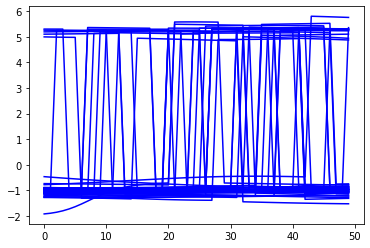

In [141]:
avg_phase = []
for event_trace, success in zip(phase_diff, mask):
    if ((1-success) == max_value_indices[4]):
        plt.plot(np.arange(len(event_trace)), event_trace, color='blue')
        avg_phase.append(circ_mean(event_trace, 0))
avg_phase = np.asarray(avg_phase)

In [137]:
print(f'Timebinned phase difference values: {avg_phase}')

Timebinned phase difference values: [-1.24964486 -0.91067315 -1.02332781 -0.88475785 -0.98436642 -0.99963534
 -0.97103579 -1.07984425 -1.08469987 -1.0654408  -0.993013   -1.1355423
 -1.17815817 -1.07414552 -1.01692555 -1.18489254 -1.10445787 -0.98510441
 -0.94894683 -0.9720939  -0.55563982 -0.98182959 -0.99594087 -0.93127765
 -0.98360548 -1.05885233 -0.81246355 -0.77541186 -1.02086853 -1.0712191
 -0.93513472 -0.86781003 -0.99387046 -0.99929371 -1.20990844 -1.1080841
 -1.01940289 -1.00822026 -1.08027391 -1.39824974 -1.00409698 -0.92523029
 -0.99393158 -0.96253549 -0.9478741  -1.32248501 -0.95340016 -1.0673204
 -0.98296323 -1.25262715]


In [135]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc(avg_phase), max_value, rtol=rtol, atol=atol)
print(f'Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.') 

Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.


#### Intermediate value

In [126]:
np.random.seed(202410)
target_value = 0.4 # We are going to choose PPC = 0.4 as an intermediate value, since we observe that in our data PPC values tend to range from just below 0 to 0.8
intermediate_value_indices_list = [] # There are generally many values in the electrode synchrony that 
for iElec in np.arange(reference_elsymx.shape[0]):
    for jElec in np.arange(reference_elsymx.shape[1]):
        for iFreq in np.arange(reference_elsymx.shape[2]):
            for iEpoch in np.arange(reference_elsymx.shape[3]):
                for iSuccess in np.arange(reference_elsymx.shape[4]):
                    if target_value - 0.05 < reference_elsymx[iElec, jElec, iFreq, iEpoch, iSuccess] < target_value + 0.05:
                        intermediate_value_indices_list.append((iElec, jElec, iFreq, iEpoch, iSuccess))
intermediate_value_indices_idx = np.random.choice(np.arange(len(intermediate_value_indices_list)))              
intermediate_value_indices = intermediate_value_indices_list[intermediate_value_indices_idx]
intermediate_value = reference_elsymx[intermediate_value_indices]
print(f'The intermediate value {intermediate_value} is located at indices: {intermediate_value_indices}.')

The intermediate value 0.39744055009565876 is located at indices: (51, 43, 3, 3, 0).


In [127]:
epoch_idx = intermediate_value_indices[3]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
phase_diff = (phase.isel(channel = intermediate_value_indices[0]) - phase.isel(channel = intermediate_value_indices[1])).isel(frequency = intermediate_value_indices[2]).isel(time = epoch).data

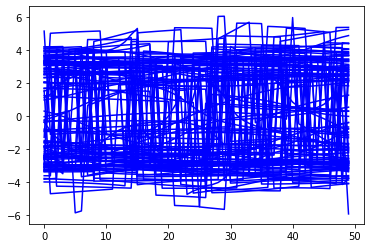

In [128]:
avg_phase = []
for event_trace, success in zip(phase_diff, mask):
    if ((1-success) == intermediate_value_indices[4]):
        plt.plot(np.arange(len(event_trace)), event_trace, color='blue')
        avg_phase.append(circ_mean(event_trace, 0))
avg_phase = np.asarray(avg_phase)

In [963]:
print(f'Timebinned phase difference values: {avg_phase}')

Timebinned phase difference values: [ 4.98506976e-01  7.50524839e-01  7.06071462e-03 -4.74162264e-01
 -1.41878168e+00 -5.62489892e-01  2.28393805e-03  2.78717126e-01
 -7.40340734e-01  6.49387035e-01 -4.48673708e-01 -3.14741059e-01
 -7.73451644e-01 -3.62674469e-01 -1.64460917e+00  3.82573041e-01
  2.34542104e-01 -2.51849838e+00 -7.67979799e-01  1.85557009e+00
  1.48170910e+00 -1.27157655e+00 -5.81986243e-01 -7.66656019e-02
 -5.89316418e-01 -2.32115433e-01  1.56438532e-01 -6.25775890e-02
  1.33249277e-01 -1.79060215e+00 -6.65002888e-01  1.09253864e-01
 -4.82114331e-01 -7.34387162e-01 -1.15611305e+00  9.55299716e-01
 -1.89405280e+00  9.36369613e-01 -1.35214659e+00  1.33782825e+00
 -6.55421307e-01 -7.07414000e-01 -9.24805773e-01 -1.59356590e+00
 -1.86568719e+00 -1.24154091e+00 -6.91911130e-01 -3.35813264e-01
 -5.24556882e-01  4.25998463e-01]


In [964]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc(avg_phase), intermediate_value, rtol=rtol, atol=atol)
print(f'Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.') 

Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.


#### Minimum value

In [904]:
min_value = np.nanmin(reference_elsymx)
min_value_indices = ()
for iElec in np.arange(reference_elsymx.shape[0]):
    for jElec in np.arange(reference_elsymx.shape[1]):
        for iFreq in np.arange(reference_elsymx.shape[2]):
            for iEpoch in np.arange(reference_elsymx.shape[3]):
                for iSuccess in np.arange(reference_elsymx.shape[4]):
                    if reference_elsymx[iElec, jElec, iFreq, iEpoch, iSuccess] == min_value:
                        min_value_indices = (iElec, jElec, iFreq, iEpoch, iSuccess)
                        print(f'The minimum value {min_value} is located at indices: {min_value_indices}.')

The minimum value -0.020408061875096167 is located at indices: (42, 53, 1, 1, 1).
The minimum value -0.020408061875096167 is located at indices: (53, 42, 1, 1, 1).


In [905]:
epoch_idx = min_value_indices[3]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
phase_diff = (phase.isel(channel = min_value_indices[0]) - phase.isel(channel = min_value_indices[1])).isel(frequency = min_value_indices[2]).isel(time = epoch).data

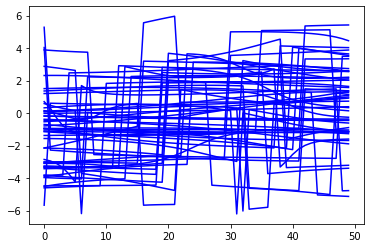

In [906]:
avg_phase = []
for event_trace, success in zip(phase_diff, mask):
    if ((1-success) == min_value_indices[4]):
        plt.plot(np.arange(len(event_trace)), event_trace, color='blue')
        avg_phase.append(circ_mean(event_trace, 0))
avg_phase = np.asarray(avg_phase)

In [907]:
print(f'Timebinned phase difference values: {avg_phase}')

Timebinned phase difference values: [-1.27972736  0.0348298   3.03573286 -0.98273016  3.075352    0.67822533
 -2.72926956  0.16096724  1.95826984  2.54844562  0.24615075 -0.24229446
  0.09517172  1.53470561  2.90578641 -1.0235629   0.72297841 -1.37520807
  1.8895013  -1.82488051 -0.72208761  2.52393778 -0.19236924  2.68454364
  1.46023972  2.19439622  2.32422429  1.40539791 -2.77729747 -2.51687869
  0.49362484 -2.95736634  1.05895169 -1.17244949 -1.75315365 -2.6650849
 -1.56205905  1.88953621 -0.34466264 -1.00401222 -1.26390474 -0.2931383
  2.77474331 -1.11785073  1.3499133  -2.61333565  2.72254498  0.06787392
 -2.09812894  1.83814186]


In [908]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc(avg_phase), min_value, rtol=rtol, atol=atol)
print(f'Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.') 

Check passed. PPC value computed from this visually inspected re-implementation matches the saved-out PPC value.


### Region synchrony matrix generation and pipeline integration

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [ ]:
beh = 'en'
sess_idx = 0
rSess = sess_list_df.iloc[sess_idx]
dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
elsymx_fname = os.path.join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
elsymx = npl(elsymx_fname)
regsymx_fname = os.path.join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
regsymx = xr.open_dataarray(regsymx_fname)

In [ ]:
iFreq = 0
iEpoch = 0
success = 0

freq = np.arange(3, 9)[iFreq]
epoch = beh_to_epochs[beh][iEpoch]
iSuccess = ~success

In [ ]:
reg1, reg2 = 'L amygdala', 'L amygdala'

In [ ]:
pairs, localization = get_pairs(dfrow), get_localization(dfrow)
regionalizations = regionalize_electrodes(pairs, localization)
region_labels = get_region_information('region_labels')
reg1_idxs, reg2_idxs = np.where(regionalizations == reg1), np.where(regionalizations == reg2)

In [ ]:
all_elsymx_entries = []
for iReg1 in reg1_idxs:
    for iReg2 in reg2_idxs:
        elsymx_entry = elsymx[iReg1, iReg2, iFreq, iEpoch, iSuccess]
        if not np.isnan(elsymx_value):
            all_elsymx_entries.append(elsymx_entry)
elsymx_value = np.mean(all_elsymx_entries)

In [ ]:
reference_value = regsymx.sel(reg1 = reg1, reg2 = reg2, freq = freq, epoch = epoch, success = success)

In [ ]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(elsymx_value, reference_value, rtol=rtol, atol=atol, equal_nan=True)

### Synchrony matrix integration test

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [ ]:
dfrow = sess_list_df.iloc[0]
beh = 'en'
events = load_events(dfrow, beh)
# start, end = beh_to_event_windows[beh]
# eeg, mask = get_eeg(dfrow, events, start, end)
# if (beh == 'rm') or (beh == 'ri'):
#     eeg = mirror_buffer(eeg, 1000)
# eeg = eeg.resampled(250)
# eeg = notch_filter(eeg, dfrow['sub'])
# freqs = np.arange(3, 9)
# phase, mask = get_phase(eeg, freqs)

In [105]:
elsymx = get_elsymx(dfrow, freqs, events)


Signature: get_elsymx(dfrow, freqs, events)
Docstring: <no docstring>
File:      ~/ConnectivityProject/<ipython-input-15-e3c72bc33757>
Type:      function


### Power computation

#### Cohen's $\textit{d}$

Source for example data: https://stackoverflow.com/questions/21532471/how-to-calculate-cohens-d-in-python

In [59]:
x = [2,4,7,3,7,35,8,9]
y = [i*2 for i in x]
# extra element so that two group sizes are not equal.
x.append(10)
known_d = -0.572015604666

In [60]:
def cohens_d(x, y):
    
    s = np.sqrt(((len(x)-1)*(np.std(x, axis=0, ddof=1)**2) + (len(y)-1)*(np.std(y, axis=0, ddof=1)**2))/(len(x)+len(y)-2))
    d = (np.mean(x, axis=0) - np.mean(y, axis=0))/s
    return d

In [61]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(cohens_d(x, y), known_d, rtol=rtol, atol=atol)
print('Check passed.')

Check passed.


#### Power timebinning

In [5]:
x = np.asarray([2*np.pi, 2*np.pi]*5)
y = np.asarray([2*np.pi]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 10), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531 6.28318531
 6.28318531 6.28318531 6.28318531 6.28318531]
Expected Output: [6.28318531 6.28318531 6.28318531 6.28318531 6.28318531]
Checks passed.


In [6]:
x = np.asarray([1e3, 2e3]*5)
y = np.asarray([1.5e3]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 10), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.]
Expected Output: [1500. 1500. 1500. 1500. 1500.]
Checks passed.


In [7]:
x = np.asarray([1e3, 2e3]*10)
y = np.asarray([1.5e3]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 20), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.]
Expected Output: [1500. 1500. 1500. 1500. 1500.]
Checks passed.


In [8]:
x = np.asarray([1e3, 2e3]*126)
y = np.asarray([1.5e3]*5)
print(f'Input: {x}')
print(f'Expected Output: {y}')
assert np.allclose(timebin_power_timeseries(x, 250), y, rtol=rtol, atol=atol)
print('Checks passed.')

Input: [1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2000.
 1000. 2000. 1000. 2000. 1000. 2000. 1000. 2

In [106]:
beh = 'en'
sess_idx = 20
dfrow = sess_list_df.iloc[sess_idx]
events = load_events(dfrow, beh)
eeg, mask = get_eeg(dfrow, events, 250-1000, 1250+1000)
if beh in ['rm', 'ri']: eeg = mirror_buffer(eeg, 1000)
eeg = eeg.resampled(250)
eeg = notch_filter(eeg, dfrow['sub'])
reference_elpomx = np.load(join(root_dir, beh, 'elpomxs', 'theta', f'{ftag(dfrow)}_elpomxd.npy'), allow_pickle=True)

In [107]:
freqs = np.arange(3, 9)
wavelet_filter = MorletWaveletFilter(freqs=freqs, width=5, output='power', complete=True)
power = wavelet_filter.filter(timeseries=eeg)
power = power.transpose('event', 'channel', 'frequency', 'time')
power = np.log10(power)
power = clip_buffer(power, 250)
power = (power - power.mean('time').mean('event'))/power.mean('time').std('event')
# power = timebin_power_timeseries(power.data, sr)

CPP total time wavelet loop:  2.1912858486175537


#### Maximum value

In [108]:
max_value = np.nanmax(reference_elpomx)
max_value_indices = ()
for iElec in np.arange(reference_elpomx.shape[0]):
        for iFreq in np.arange(reference_elpomx.shape[1]):
            for iEpoch in np.arange(reference_elpomx.shape[2]):
                    if reference_elpomx[iElec, iFreq, iEpoch] == max_value:
                        max_value_indices = (iElec, iFreq, iEpoch)
                        print(f'The maximum value {max_value} is located at indices: {max_value_indices}.')

The maximum value 0.38755645419155565 is located at indices: (35, 5, 1).


In [109]:
epoch_idx = max_value_indices[2]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
power_sel = power.isel(channel = max_value_indices[0]).isel(frequency = max_value_indices[1]).isel(time = epoch).data

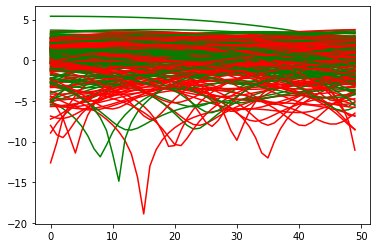

In [110]:
power_successful = []
power_unsuccessful = []
for event_trace, success in zip(power_sel, mask):
    if success:
        plt.plot(np.arange(len(event_trace)), event_trace, color='green')
        power_successful.append(np.mean(event_trace, axis=0))
    else:
        plt.plot(np.arange(len(event_trace)), event_trace, color='red')
        power_unsuccessful.append(np.mean(event_trace, axis=0))

In [111]:
cohens_d(power_successful, power_unsuccessful)

0.38755645419155543

In [112]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(cohens_d(power_successful, power_unsuccessful), max_value, rtol=rtol, atol=atol)
print(f'Check passed. Cohen\'s d value computed from this visually inspected re-implementation matches the saved-out Cohen\'s d value.') 

Check passed. Cohen's d value computed from this visually inspected re-implementation matches the saved-out Cohen's d value.


#### Minimum value

In [113]:
min_value = np.nanmin(reference_elpomx)
min_value_indices = ()
for iElec in np.arange(reference_elpomx.shape[0]):
        for iFreq in np.arange(reference_elpomx.shape[1]):
            for iEpoch in np.arange(reference_elpomx.shape[2]):
                    if reference_elpomx[iElec, iFreq, iEpoch] == min_value:
                        min_value_indices = (iElec, iFreq, iEpoch)
                        print(f'The maximum value {min_value} is located at indices: {min_value_indices}.')

The maximum value -0.5800818216825632 is located at indices: (70, 3, 4).


In [114]:
epoch_idx = min_value_indices[2]
epoch = np.arange(epoch_idx*50, epoch_idx*50+50)
power_sel = power.isel(channel = min_value_indices[0]).isel(frequency = min_value_indices[1]).isel(time = epoch).data

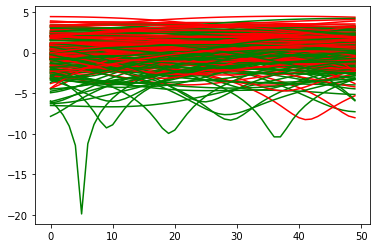

In [115]:
power_successful = []
power_unsuccessful = []
for event_trace, success in zip(power_sel, mask):
    if success:
        plt.plot(np.arange(len(event_trace)), event_trace, color='green')
        power_successful.append(np.mean(event_trace, axis=0))
    else:
        plt.plot(np.arange(len(event_trace)), event_trace, color='red')
        power_unsuccessful.append(np.mean(event_trace, axis=0))

In [116]:
cohens_d(power_successful, power_unsuccessful)

-0.5800818216825632

In [117]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(cohens_d(power_successful, power_unsuccessful), min_value, rtol=rtol, atol=atol)
print(f'Check passed. Cohen\'s d value computed from this visually inspected re-implementation matches the saved-out Cohen\'s d value.') 

Check passed. Cohen's d value computed from this visually inspected re-implementation matches the saved-out Cohen's d value.


### Region power matrix generation

### Power matrix integration test

## Find overlapping pairs

In [1232]:
pairs = get_pairs(dfrow)

In [1234]:
find_overlapping_pairs(pairs)

[(0, 0),
 (0, 1),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 1),
 (2, 2),
 (2, 3),
 (3, 2),
 (3, 3),
 (3, 4),
 (4, 3),
 (4, 4),
 (4, 5),
 (5, 4),
 (5, 5),
 (5, 6),
 (6, 5),
 (6, 6),
 (6, 7),
 (7, 6),
 (7, 7),
 (7, 8),
 (8, 7),
 (8, 8),
 (8, 9),
 (9, 8),
 (9, 9),
 (9, 10),
 (10, 9),
 (10, 10),
 (10, 11),
 (11, 10),
 (11, 11),
 (11, 12),
 (12, 11),
 (12, 12),
 (13, 13),
 (13, 14),
 (14, 13),
 (14, 14),
 (14, 15),
 (15, 14),
 (15, 15),
 (15, 16),
 (16, 15),
 (16, 16),
 (16, 17),
 (17, 16),
 (17, 17),
 (17, 18),
 (18, 17),
 (18, 18),
 (18, 19),
 (19, 18),
 (19, 19),
 (19, 20),
 (20, 19),
 (20, 20),
 (20, 21),
 (21, 20),
 (21, 21),
 (21, 22),
 (22, 21),
 (22, 22),
 (22, 23),
 (23, 22),
 (23, 23),
 (23, 24),
 (24, 23),
 (24, 24),
 (24, 25),
 (25, 24),
 (25, 25),
 (25, 26),
 (26, 25),
 (26, 26),
 (26, 27),
 (27, 26),
 (27, 27),
 (28, 28),
 (28, 29),
 (29, 28),
 (29, 29),
 (29, 30),
 (30, 29),
 (30, 30),
 (30, 31),
 (31, 30),
 (31, 31),
 (31, 32),
 (32, 31),
 (32, 32),
 (32, 33),
 (33, 32),
 (33, 33),
 (

## Electrode regionalization

In [27]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [28]:
all_pairs_regionalizations = [] # Initialize a list for gathering all the  
for iSess, rSess in sess_list_df.iterrows():
    
    dfrow = get_dfrow(iSess) # Get dfrow from session label
    pairs = get_pairs(dfrow) # Load saved-out pairs into memory
    localization = get_localization(dfrow) # Load saved-out localization into memory
                    
    atlas_labels = get_atlas_labels(pairs, localization) # Get atlas labels (pair label, region label from one of the atlases, and the name of the atlas used)
    assert len(atlas_labels) == len(pairs), f'Length of atlas_labels is {len(atlas_labels)}, but length of pairs is {len(pairs)}.' # Check that there are as many atlas labels as pairs
                    
    regionalizations = regionalize_electrodes(pairs, localization) # Get "unified" region labels for all pairs
    assert len(regionalizations) == len(pairs), f'Length of regionalizations is {len(regionalizations)}, but length of pairs is {len(pairs)}.' # Check that there are as many regionalizations as pairs
                    
    pairs_regionalizations = pd.concat([pairs[['contact_1', 'contact_2']], atlas_labels], axis=1) # Initialize a new DataFrame that has information from pairs, atlas labels, and regionalizations for the sake of verification
    pairs.set_index('label', inplace=True) # Set the so that we can look up a pair's region label from a certain atlas
    pairs_regionalizations['atlas_label_from_pairs'] = pairs_regionalizations.apply(lambda r: pairs.loc[r['pair_label'], r['atlas']] if not r['atlas'] == 'no atlas' else 'nan', axis=1)
    pairs.reset_index(inplace=True)
    
    hemisphere_cols = np.intersect1d(['mni.x','ind.corrected.x', 'ind.snap.x', 'ind.dural.x', 'ind.x', 'avg.corrected.x', 'avg.snap.x', 'avg.dural.x', 'avg.x', 'tal.x', 'x', 'hemisphere', 'Loc2'], pairs.columns)
    pairs_regionalizations[hemisphere_cols] = pairs[hemisphere_cols]
    pairs_regionalizations['regionalization'] = regionalizations # Add regionalizations to pairs_regionalization DataFrame
    pairs_regionalizations[['sub', 'exp', 'sess', 'loc', 'mon']] = dfrow # Add the session label to the DataFrame
    
    all_pairs_regionalizations.append(pairs_regionalizations)

all_pairs_regionalizations = pd.concat(all_pairs_regionalizations)

In [29]:
# Check that atlas label generated by the get_atlas_labels() function matches the entry from the corresponding atlas
assert (all_pairs_regionalizations['atlas_label'] == all_pairs_regionalizations['atlas_label_from_pairs']).all()

In [66]:
def check_hemisphere_label(r):
    
    atlases_x = np.intersect1d(['mni.x','ind.corrected.x', 'ind.snap.x', 'ind.dural.x', 'ind.x', 'avg.corrected.x', 'avg.snap.x', 'avg.dural.x', 'avg.x', 'tal.x', 'x'], r.keys())
    atlases_x = np.asarray([atlas_x for atlas_x in atlases_x if not pd.isna(r[atlas_x])])
    
    hemisphere_label_correct = False
    
    if 'L' in str(r['regionalization']):
            
        c1 = ( ('left' in r['atlas_label'].lower()) | (np.any([float(r[atlas_x]) < 0 for atlas_x in atlases_x])) )
        if 'Loc2' in r.keys(): c1 = ( c1 | ('left' in str(r['Loc2']).lower()))
        c2 = 'right' not in r['atlas_label'].lower()
        c3 = np.all([float(r[atlas_x]) < 0 for atlas_x in atlases_x])
        c4 = 'right' not in str(r['Loc2']).lower() if 'Loc2' in r.keys() else True
        hemisphere_label_correct = c1 & c2 & c3 & c4
        
    elif 'R' in str(r['regionalization']):
            
        c1 = ( ('right' in r['atlas_label'].lower()) | (np.any([float(r[atlas_x]) > 0 for atlas_x in atlases_x])) )
        if 'Loc2' in r.keys(): c1 = ( c1 | ('right' in str(r['Loc2']).lower()))
        c2 = 'left' not in r['atlas_label'].lower()
        c3 = np.all([float(r[atlas_x]) > 0 for atlas_x in atlases_x])
        c4 = 'left' not in str(r['Loc2']).lower() if 'Loc2' in r.keys() else True
        hemisphere_label_correct = c1 & c2 & c3 & c4
            
    elif pd.isna(r['regionalization']):
        
        c1 = ('left' not in r['atlas_label'].lower()) & ('right' not in r['atlas_label'].lower())
        c2 = np.all([( (np.isnan(r[atlas_x])) | (r[atlas_x] == 0) ) for atlas_x in atlases_x])
        c3 = ('left' not in str(r['Loc2']).lower()) & ('right' not in str(r['Loc2']).lower()) if 'Loc2' in r.keys() else True
        hemisphere_label_correct = c1 & c2 & c3
        
    return hemisphere_label_correct
        
all_pairs_regionalizations['hemisphere_label_check'] = all_pairs_regionalizations.apply(lambda r: check_hemisphere_label(r), axis=1)
all_pairs_regionalizations.reset_index(inplace=True)

In [90]:
failed_hemisphere_label_check = all_pairs_regionalizations.query('hemisphere_label_check == False')
assert not pd.isna(failed_hemisphere_label_check['regionalization']).any()
assert not (pd.isna(failed_hemisphere_label_check['mni.x']) & pd.isna(failed_hemisphere_label_check['ind.x'])).any()

In [98]:
region_labels = get_region_information('region_labels')
for region in region_labels:
    this_region_atlas_labels = all_pairs_regionalizations.query('regionalization == @region')['atlas_labels'].unique()
    print(f'{region}: {this_region_atlas_labels}')

KeyError: 'atlas_labels'

## Helper functions

### Matrix operations

#### Symmetrization

In [36]:
A = [[np.nan, np.nan, np.nan], 
     [5, np.nan, np.nan],
     [6, 7, np.nan]]
A_out = [[np.nan, 5, 6], 
         [5, np.nan, 7],
         [6, 7, np.nan]]

B1 = [[np.nan, np.nan, np.nan], 
      [5, np.nan, np.nan],
      [6, 7, np.nan]]
B2 = [[np.nan, 5, 6], 
      [np.nan, np.nan, 7],
      [np.nan, np.nan, np.nan]]
B_out1 = [[np.nan, 5, 6], 
          [5, np.nan, 7],
          [6, 7, np.nan]]
B_out2 = [[np.nan, 5, 6], 
         [5, np.nan, 7],
         [6, 7, np.nan]]

for var in ['A', 'A_out', 'B1', 'B2', 'B_out1', 'B_out2']: globals()[var] = np.asarray(globals()[var])

B1 = B1[..., np.newaxis]
B2 = B2[..., np.newaxis]
B = np.concatenate([B1, B2], axis=-1)

B_out1 = B_out1[..., np.newaxis]
B_out2 = B_out2[..., np.newaxis]
B_out = np.concatenate([B_out1, B_out2], axis=-1)



In [37]:
rtol = 1e-5
atol = 1e-8
assert np.allclose(symmetrize(A), A_out, rtol=rtol, atol=atol, equal_nan=True)
assert np.allclose(symmetrize(B), B_out, rtol=rtol, atol=atol, equal_nan=True)
print('Checks passed.')

Checks passed.


### JZS Bayes factor calculation

In [441]:
rtol = 0.015

target_BF_value = 10
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([100, 200, 500], 
                  [0.69, 1.08, 1.44]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')
        
target_BF_value = 3
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([5, 10, 20, 50, 100, 200, 500], 
                  [0.40, 0.89, 1.20, 1.51, 1.72, 1.90, 2.12]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')
    
target_BF_value = 1/3
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([5, 10, 20, 50, 100, 200, 500], 
                  [3.15, 2.73, 2.64, 2.68, 2.76, 2.86, 2.99]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')
    
target_BF_value = 1/10
error = target_BF_value * rtol
lower_bound = target_BF_value - error
upper_bound = target_BF_value + error
for (N, t) in zip([5, 10, 20, 50, 100, 200, 500], 
                  [4.97, 3.60, 3.26, 3.17, 3.20, 3.27, 3.38]):
    BF_value = jzs_bayes_factor(t, N)
    assert lower_bound < BF_value < upper_bound, f'Check failed | BF_value: {BF_value}, t: {t}, N: {N}'
print(f'All checks passed with target BF value {target_BF_value}. Permitted error: {error:.2}. Lower bound: {lower_bound:.2}. Upper bound: {upper_bound:.2}.')

All checks passed with target BF value 10. Permitted error: 0.15. Lower bound: 9.8. Upper bound: 1e+01.
All checks passed with target BF value 3. Permitted error: 0.045. Lower bound: 3.0. Upper bound: 3.0.
All checks passed with target BF value 0.3333333333333333. Permitted error: 0.005. Lower bound: 0.33. Upper bound: 0.34.
All checks passed with target BF value 0.1. Permitted error: 0.0015. Lower bound: 0.099. Upper bound: 0.1.


## Regsymx checks

In [110]:
def check_regsymx(dfrow):
    
    dfrow = get_dfrow(dfrow)
    
    for beh in ['en', 'rm', 'ri']:
        pairs, localization = get_pairs(dfrow), get_localization(dfrow)
        regionalizations = regionalize_electrodes(pairs, localization)
        regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
        elsymx_fname = os.path.join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        if not ex(elsymx_fname): continue
        elsymx = npl(elsymx_fname)
        elsymx_regs = add_regions_elsymx(elsymx, regionalizations, np.arange(3,9), beh)
        regsymx = regionalize_electrode_connectivities(elsymx_regs)
        
        reference_regsymx_fname = os.path.join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        reference_regsymx = xr.open_dataarray(reference_regsymx_fname)

        matches = np.allclose(regsymx.data, reference_regsymx.data, equal_nan=True)
        if not matches: np.save(join(root_dir, 'regsymx_checks', f'{ftag(dfrow)}_{beh}.npy'), reference_regsymx_fname)
        
    for beh in ['en', 'rm', 'ri']:
        for iShuffle in np.arange(1, 21):
            pairs, localization = get_pairs(dfrow), get_localization(dfrow)
            regionalizations = regionalize_electrodes(pairs, localization)
            regionalizations = exclude_regionalizations(dfrow, pairs, regionalizations)
            elsymx_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
            if not ex(elsymx_fname): continue
            elsymx = npl(elsymx_fname)
            elsymx_regs = add_regions_elsymx(elsymx, regionalizations, np.arange(3,9), beh)
            regsymx = regionalize_electrode_connectivities(elsymx_regs)

            reference_regsymx_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
            reference_regsymx = xr.open_dataarray(reference_regsymx_fname)

            matches = np.allclose(regsymx.data, reference_regsymx.data, equal_nan=True)
            if not matches: np.save(join(root_dir, 'regsymx_checks', f'{ftag(dfrow)}_{beh}_shuffled{iShuffle}.npy'), reference_regsymx_fname)

In [115]:
np.all([future.status == 'finished' for future in futures])

True

In [116]:
client.shutdown()

In [111]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
sess_list = sess_list_df[['sub', 'exp', 'sess', 'loc', 'mon']].values

In [112]:
client = cl('check_regsymx', '10G', int(4000/10), walltime=100000) 
futures = client.map(check_regsymx, sess_list)
wait(futures, client, check_delay=30)

Unique port for amrao is 51507
{'dashboard_address': ':51507'}
To view the dashboard, run: 
`ssh -fN amrao@rhino2.psych.upenn.edu -L 8000:192.168.86.141:51507` in your local computer's terminal (NOT rhino) 
and then navigate to localhost:8000 in your browser


distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
concurrent.futures._base.CancelledError


In [221]:
check_regsymx(('R1001P','FR1',0,0,0))

In [222]:
check_regsymx(('TJ005','pyFR',1,0,0))

In [223]:
check_regsymx(('TJ005','pyFR',2,0,0))

In [245]:
regsymx_check_dir = '/scratch/amrao/retrieval_connectivity/regsymx_checks'
for regsymx_check_fname in ld(regsymx_check_dir):
    regsymx_check_path = join(regsymx_check_dir, regsymx_check_fname)
    regsymx_path = str(npl(regsymx_check_path))
    if 'ri' in regsymx_path: print(regsymx_check_fname)
    os.system(f'rm {regsymx_path}')

TJ005_pyFR_2_rm.npy
R1001P_FR1_1_en_shuffled5.npy
R1309M_FR1_2_en_shuffled2.npy
R1167M_catFR1_0_rm.npy
R1323T_FR1_0_en_shuffled1.npy
R1230J_FR1_5_en_shuffled5.npy
TJ077_pyFR_1_en_shuffled3.npy
TJ041_pyFR_4_en_shuffled10.npy
R1202M_catFR1_1_en_shuffled5.npy
R1299T_FR1_1_en_shuffled6.npy
R1351M_FR1_0_en_shuffled8.npy
R1346T_FR1_1_en_shuffled4.npy
R1196N_FR1_1_en_shuffled10.npy
R1231M_catFR1_0_en_shuffled14.npy
R1498D_catFR1_4_en_shuffled6.npy
R1501J_catFR1_5_en_shuffled12.npy
R1497T_catFR1_0_en_shuffled15.npy
R1315T_FR1_2_en_shuffled14.npy
R1154D_FR1_1_rm_shuffled17.npy
R1375C_catFR1_3_en_shuffled2.npy
R1231M_FR1_0_en_shuffled4.npy
R1164E_FR1_0_en_shuffled3.npy
R1477J_catFR1_2_en.npy
R1147P_FR1_0_en_shuffled3.npy
R1111M_FR1_1_en.npy
TJ034_pyFR_1_rm_shuffled7.npy
UP024_pyFR_1_en.npy
TJ005_pyFR_4_0_1_en_shuffled5.npy
R1637T_catFR1_0_en_shuffled4.npy
UP011_pyFR_0_en_shuffled12.npy
UP041_pyFR_1_en_shuffled2.npy
R1390M_catFR1_1_en_shuffled8.npy
UP007_pyFR_1_en_shuffled18.npy
TJ025_pyFR_0_en_s

## Matrix aggregation

In [4]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error  ... no_matches_rm  \
sub    exp sess loc mon                                   ...                 
R1001P FR1 0    0   0    True      cmlreaders        NaN  ...          19.0   
           1    0   0    True      cmlreaders        NaN  ...          15.0   
R1002P FR1 0    0   0    True      cmlreaders        NaN  ...          46.0   
           1    0   0    True      cmlreaders        NaN  ...          23.0   
R1003P FR1 0    0   0    True      cmlreaders        NaN  ...          23.0   

                         mean_succ_times_rm  mean_unsucc_times_rm  \
sub    exp sess loc mon                                             
R1001P FR1 0    0   0          13339.947368          12390.000000   
           1    0   0           9179.200000           9117.400000   
R1002P FR1 0    0   0          13129.239130          12938.630435   
           1    0   0          11955.956522          11924.826087   
R1003P FR1 0    0   0          13344.086957          12047.043478   

                         no_matches_ri  mean_succ_times_ri  \
sub    exp sess loc mon                                      
R1001P FR1 0    0   0             17.0        13803.588235   
           1    0   0             13.0         9279.384615   
R1002P FR1 0    0   0              NaN                 NaN   
           1    0   0              NaN                 NaN   
R1003P FR1 0    0   0             23.0        13344.086957   

                         mean_unsucc_times_ri  recall_rate  en_match_rate  \
sub    exp sess loc mon                                                     
R1001P FR1 0    0   0            14292.176471     0.206667       0.176667   
           1    0   0            10227.769231     0.210000       0.206667   
R1002P FR1 0    0   0                     NaN     0.390000       0.356667   
           1    0   0                     NaN     0.400000       0.360000   
R1003P FR1 0    0   0            13791.652174     0.325758       0.303030   

                        rm_match_rate  ri_match_rate  
sub    exp sess loc mon                               
R1001P FR1 0    0   0        0.306452       0.274194  
           1    0   0        0.238095       0.206349  
R1002P FR1 0    0   0        0.393162            NaN  
           1    0   0        0.191667            NaN  
R1003P FR1 0    0   0        0.267442       0.267442  

[5 rows x 45 columns]

In [5]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

In [11]:
reg1, reg2 = 'L hippocampus', 'R hippocampus'
region_labels = get_region_information('region_labels')

In [18]:
beh = 'rm'
iFreq = 4
iEpoch = 4
success = 1

freq = np.arange(3, 9)[iFreq]
epoch = beh_to_epochs[beh][iEpoch]

In [19]:
all_sub_values = []
for sub in sublist:
    
    this_sub_values = []
    this_sub_session_list = sess_list_df.query('sub == @sub')
    montage_count = len(this_sub_session_list['mon'].unique())
    montage_session_count = [len(this_sub_session_list.query('mon==@mon')) for mon in this_sub_session_list['mon'].unique()]
    
    for iSess, rSess in this_sub_session_list.iterrows():

        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
        mx_fname = os.path.join(root_dir, beh, 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
        mx = xr.open_dataarray(mx_fname).sel(reg1 = reg1, reg2 = reg2, freq = freq, epoch = epoch, success = success)
        value = float(mx.data)
        if not np.isnan(value):
            this_sub_values.append(value)

    assert len(this_sub_values) in [0, len(this_sub_session_list), *montage_session_count], f'{sub}'
    if len(this_sub_values) == 0: continue
    mean_sub_value = np.mean(this_sub_values)
    assert not np.isnan(mean_sub_value)
    all_sub_values.append(mean_sub_value)

check_value = np.mean(all_sub_values)   

In [20]:
symx = xr.open_dataarray(os.path.join(root_dir, f'{beh}_pop_symx.nc'))
aggregated_value = float(symx.sel(reg1 = reg1, reg2 = reg2, freq = freq, epoch = epoch, success = success).mean('sub').values)

In [21]:
check_value

0.007255821430389301

In [22]:
aggregated_value

0.007255821430389301

In [23]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(check_value, aggregated_value, rtol=rtol, atol=atol, equal_nan=True)

## Effect size correlation analyses

### Trial count

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [38]:
for sub in sublist:
    for beh in ['en', 'rm']:
        this_sub_session_list = sess_list_df.query('sub == @sub')
        count = 0
        for iSess, rSess in this_sub_session_list.iterrows():
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            events = load_events(dfrow, beh)
            count += len(events)//2
        assert count == get_sub_trial_count(sub, beh, sess_list_df)

sess_list_df_ri = sess_list_df.query('ri_events == True')
sublist_ri = sess_list_df_ri['sub'].unique()
for sub in sublist_ri:
    for beh in ['ri']:
        this_sub_session_list = sess_list_df_ri.query('sub == @sub')
        count = 0
        for iSess, rSess in this_sub_session_list.iterrows():
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            events = load_events(dfrow, beh)
            count += len(events)//2
        assert count == get_sub_trial_count(sub, beh, sess_list_df_ri)

NameError: name 'load_events' is not defined

In [ ]:
for beh in ['en', 'rm']:
    mx_fname = os.path.join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq').mean('reg1').mean('reg2')
    mx = mx.sel(success=1) - mx.sel(success=0)
    subs = mx.sub
    mx = mx.data
    
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    for i, r in event_count_effect_size_sub_list_df.iterrows():
        assert r[f'{beh}_event_count'] == get_sub_trial_count(r['sub'], beh, sess_list_df)
        sub_idx = np.where(subs == r['sub'])[0]
        assert r[f'{beh}_effect_size'] == mx[sub_idx]
    
        
for beh in ['ri']:
    mx_fname = os.path.join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(mx_fname)
    mx = mx.sel(success=1) - mx.sel(success=0)
    subs = mx.sub
    mx = mx.data
    
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    for i, r in event_count_effect_size_sub_list_df.iterrows():
        assert r[f'{beh}_event_count'] == get_sub_trial_count(r['sub'], beh, sess_list_df_ri)
        sub_idx = np.where(subs == r['sub'])[0]
        assert r[f'{beh}_effect_size'] == mx[sub_idx]

In [ ]:
for beh in ['en', 'rm', 'ri']:
    np.random.seed(202409)
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    rs = []
    r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_event_count'].values,
                             event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
    rs.append(r)
    for _ in range(999):
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_event_count'].values)
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)
        r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_event_count'].values,
                                 event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
        rs.append(r)
    rs = np.asarray(rs)
    print(f'r = {rs[0]}, p = {(np.abs(rs) >= np.abs(rs[0]))/1000}')

### Noise floor

In [303]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

In [443]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 subjects being analyzed.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R

In [92]:
dfrow = sess_list_df.iloc[50]
beh = 'en'
freqs = np.arange(3, 9)
events = load_events(dfrow, beh) # Load events for this dfrow and behavioral contrast
events['event_idx'] = np.arange(len(events))
events.sort_values(by=['mstime', 'eegoffset'], inplace=True)
iShuffle = 19
shuffled_mask_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'shuffled_masks', f'{ftag(dfrow)}_shuffled_mask.npy')
print(shuffled_mask_fname)
shuffled_mask = npl(shuffled_mask_fname)[events['event_idx'].values]

/scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_19/shuffled_masks/R1367D_catFR1_0_shuffled_mask.npy


In [77]:
iElec1, iElec2 = 5, 10
iFreq = 4
iEpoch = 4
success = 1

freq = np.arange(3, 9)[iFreq]
epoch = beh_to_epochs[beh][iEpoch]
iSuccess = 1 - success

In [80]:
phase, mask, sr = process_phase(dfrow, events, freqs)
phase_diff = (phase.isel(channel = iElec1) - phase.isel(channel = iElec2)).data
phase_diff = timebin_phase_timeseries(phase_diff, sr)
if success: ppc_value = ppc(phase_diff[shuffled_mask, ...])
else: ppc_value = ppc(phase_diff[~shuffled_mask, ...])
ppc_value = ppc_value[iFreq, iEpoch]

In [81]:
reference_elsymx_fname = os.path.join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
print(reference_elsymx_fname)
reference_elsymx = npl(reference_elsymx_fname)
reference_value = reference_elsymx[iElec1, iElec2, iFreq, iEpoch, iSuccess]

/scratch/amrao/retrieval_connectivity/noise_floor_analysis/en/shuffle_19/elsymxs/R1001P_FR1_0_elsymx.npy


In [82]:
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc_value, reference_value, rtol=rtol, atol=atol), f'{ppc_value:.5}, {reference_value:.5}'

In [ ]:
beh = 'en'
dfrow = sess_list_df.iloc[0]
noise_floors = []
for _ in np.arange(1, 21):
    fname = join(root_dir, 'noise_floor_analysis', beh, f'shuffle_{iShuffle}', 'regsymxs', f'{ftag(dfrow)}_regsymx.nc')
    mx = xr.open_dataarray(fname).mean('epoch').mean('freq').mean('reg1').mean('reg2')
    mx = mx.sel(success=1) - mx.sel(success=0)
    value = float(mx.data)
    noise_floors.append(value)
noise_floors = np.asarray(noise_floors)
assert np.all(noise_floors = npl(join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')))
    

In [ ]:
for beh in ['en', 'rm', 'ri']:
    
    mx_fname = os.path.join(root_dir, f'{beh}_pop_symx.nc')
    mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq').mean('reg1').mean('reg2')
    mx = mx.sel(success=1) - mx.sel(success=0)
    subs = mx.sub
    mx = mx.data
    
    noise_floor_effect_size_sublist_df = get_noise_floor_effect_size(beh)
    for i, r in noise_floor_effect_size_sublist_df.iterrows():
        
        sub_idx = np.where(subs == r['sub'])[0]
        assert r[f'{beh}_effect_size'] == mx[sub_idx]
        
        noise_floors = []
        noise_floor_fname = join(root_dir, 'noise_floor_analysis', beh, 'noise_floor_estimates', f'{ftag(dfrow)}_noise_floor_estimate.npy')
        noise_floor = npl(noise_floor_fname)
        noise_floor = np.mean(noise_floor)
        
        assert r[f'{beh}_noise_floor'] == noise_floor

In [ ]:
for beh in ['en', 'rm', 'ri']:
    np.random.seed(202409)
    event_count_effect_size_sub_list_df = get_event_count_effect_size(beh)
    rs = []
    r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_noise_floor'].values,
                             event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
    rs.append(r)
    for _ in range(999):
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_noise_floor'].values)
        np.random.shuffle(event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)
        r = scipy.stats.pearsonr(event_count_effect_size_sub_list_df[f'{beh}_noise_floor'].values,
                                 event_count_effect_size_sub_list_df[f'{beh}_effect_size'].values)[0]
        rs.append(r)
    rs = np.asarray(rs)
    print(f'r = {rs[0]}, p = {(np.abs(rs) >= np.abs(rs[0]))/1000}')

## Hub analysis

### Check $\textit{t}$-statistics for hub tables

In [1125]:
hub_tables = load_pickle(join(root_dir, 'hub_tables.pkl'))

In [1129]:
for beh in ['en', 'rm', 'ri']:
    min_hub_t = hub_tables[beh].query('hub == True')['t'].min()
    max_nonhub_t = hub_tables[beh].query('hub == False')['t'].max()
    print(min_hub_t, max_nonhub_t)
    assert max_nonhub_t <= min_hub_t

1.9466492453006774 1.8586761139135435
1.5291392480818253 1.50864770786415
1.9576170317026567 1.8384701901890137


When it was originally implemented, the shuffling used the following

In [242]:
value_count = 100
stds_1 = []
stds_2 = []
shuffle_count = 10000
for _ in range(value_count):
    flip_masks1 = np.asarray([(2*((np.random.random(size=379)>=0.5)-0.5)).astype(int) for _ in range(shuffle_count)])
    flip_masks2 = np.random.choice([-1, 1], size=flip_masks1.shape)
    std_1 = np.std(np.mean(flip_masks1, axis=-1), axis=0)
    std_2 = np.std(np.mean(flip_masks2, axis=-1), axis=0)
    stds_1.append(std_1)
    stds_2.append(std_2)

In [247]:
assert np.isclose(np.mean(stds_1), np.mean(stds_2), rtol=1e-2, atol=1e-8)
print('Check passed.')

Check passed.


In [248]:
beh='en'
symx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq').mean('reg2')  

In [256]:
ts = []

shuffle_count = 10000
flip_masks = []
for _ in range(shuffle_count):
    idxs = (2*((np.random.random(size=len(symx.sub.values))>=0.5)-0.5)).astype(int)
    flip_masks.append(idxs)
flip_masks = np.asarray(flip_masks)
# flip_masks = np.random.choice([-1, 1], size=(shuffle_count, len(symx.sub)))

for reg in symx.reg1.values:
    symx_sel = symx.sel(reg1=reg)
    ppc_successful, ppc_unsuccessful = symx_sel.sel(success=1).data, symx_sel.sel(success=0).data
    if len(finitize(ppc_successful)) < 7: continue
    for flip_mask in flip_masks:
        t1 = scipy.stats.ttest_1samp(finitize((ppc_successful-ppc_unsuccessful)*flip_mask),popmean=0)[0]
        ppc_ = np.vstack([ppc_successful, ppc_unsuccessful])
        for idx, flip in enumerate(flip_mask):
            if flip == -1:
                a, b = ppc_[0, idx], ppc_[1, idx]
                ppc_[0, idx] = b
                ppc_[1, idx] = a
        t2 = scipy.stats.ttest_rel(finitize(ppc_[0, :]), finitize(ppc_[1, :]))[0]
        assert t1 == t2
        ts.append(t2)

In [282]:
true_ts = hub_tables['en']['t'].values
M = (~pd.isna(true_ts)).sum()
p0 = np.sum((np.quantile(ts, 0.25) <= true_ts) & (true_ts <= np.quantile(ts, 0.75)))/(0.5*M)
p0 = np.min([p0, 1])
print(f'M = {M}, p0 = {p0}')

M = 70, p0 = 0.7714285714285715


In [288]:
PPC_successful = finitize(symx.sel(reg1 = 'L amygdala', success=1).data)
PPC_unsuccessful = finitize(symx.sel(reg1 = 'L amygdala', success=0).data)
t = scipy.stats.ttest_rel(PPC_successful, PPC_unsuccessful)[0]
print(f'Number of subjects: {len(PPC_successful)}, t = {t:.3}')

Number of subjects: 124, t = 3.17


In [280]:
p_fdr = t * np.sum(x
p_fdr *= p0
print(p_fdr)

350000

In [473]:
for beh in ['en', 'rm', 'ri']:
    hub_tables[beh]['p'] = hub_tables[beh].apply(lambda r: np.sum(np.abs(t_distributions[beh]) >= np.abs(r['t']))/len(ts) if not np.isnan(r['t']) else np.nan, axis=1)


In [448]:
hub_tables['rm']['p']

0     0.000004
1     0.545400
2     0.000234
3          NaN
4     0.442574
5          NaN
6     0.249937
7     0.127096
8     0.017470
9     0.000587
10    0.000000
11    0.052270
12    0.001087
13    0.004711
14    0.006573
15    0.181807
16    0.352036
17    0.965477
18    0.239910
19    0.991704
20    0.000026
21    0.000001
22    0.000306
23    0.693269
24    0.000060
25    0.007640
26    0.507821
27    0.067380
28    0.503119
29    0.590394
30         NaN
31    0.011481
32    0.932281
33    0.000001
34    0.200879
35    0.290204
36    0.002246
37         NaN
38    0.326786
39         NaN
40    0.020317
41    0.019007
42    0.000320
43         NaN
44    0.141494
45         NaN
46    0.542443
47    0.253670
48    0.805613
49    0.000053
50    0.000087
51    0.000163
52    0.187353
53    0.000001
54    0.000027
55    0.076240
56    0.051096
57    0.647820
58    0.058200
59    0.287527
60    0.000316
61    0.000000
62    0.000044
63    0.274060
64    0.000203
65    0.701863
66    0.20

In [335]:
np.sum(np.abs(ts) >= np.abs(ht.loc['L amygdala'].t))/(10000*70)

0.00176

In [465]:
A=np.asarray([x for i,x in enumerate(hub_tables['ri']['reg']) if hub_tables['ri'].iloc[i]['sub_count'] >=7])

In [467]:
A[mask]

array(['L hippocampus'], dtype='<U28')

In [477]:
import statsmodels
statsmodels.stats.multitest.fdrcorrection(finitize(hub_tables['ri']['p'].values),method='p')[0].sum()

1

In [472]:
0.11950000000000001*p0

0.0921857142857143

In [344]:
import statsmodels
statsmodels.stats.multitest.fdrcorrection(finitize(ht[max_null_Ts'p'].values), method='p')

(array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False]),
 array([0.1232    , 0.70084722, 0.2596    , 0.2596    , 0.78015128,
        0.929005  , 0.97035797, 0.92858772, 0.58858182, 0.96508676,
        0.96508676, 0.35918889, 0.584     , 0.89183019, 0.838942  ,
        0.57744194, 0.929005  , 0.664     , 0.89183019, 0.13586667,
        0.24221667, 0.93215246, 0.57744194, 0.28949286, 0.98892571,
        0.35918889, 0.786365  , 0.83949216, 0.24221667, 0.79024419,
        0.57744194, 0.79024419, 0.90

In [369]:
t_shuffled = np.asarray([np.asarray(x) for x in ht['t_shuffled'].values if len(x) > 0])

In [373]:
max_null_Ts = np.max(t_shuffled,axis=0)

In [376]:
q=np.quantile(max_null_Ts, 0.975)

In [385]:
A = mx.mean('reg2').sel(reg1 = 'R amygdala')

In [386]:
scipy.stats.ttest_1samp(finitize(A.data),0)

Ttest_1sampResult(statistic=0.728934853996643, pvalue=0.46785379404618344)

In [379]:
T_vals

array([ 3.17061263,  0.94757684,  2.01840261,  2.00179348,  0.81429074,
        0.27597264,  0.05763315, -0.33755484,  1.11530326, -0.08270219,
        0.15091309,  1.70738415,  1.13926431, -0.44740189, -0.55557238,
        1.16929308,  0.27355046,  1.00235759, -0.4425068 ,  2.81418446,
        2.33962033, -0.25174611,  1.22623941,  1.92375329,  0.01491939,
        1.71263478,  0.78938208, -0.53535911,  2.40192782,  0.7425315 ,
        1.21803862,  0.73513716,  0.41125495,  1.4648342 ,  0.60951013,
        0.72893485,  1.61811445,  1.20266687, -1.42284216,  0.12590719,
        1.2645909 ,  0.21979702,  1.16514991,  0.65649561,  0.32895864,
        1.79983074,  2.78681967,  2.11287194,  0.28107259,  1.73672915,
        0.89752994,  2.08138838,  0.69487039,  0.16745666,  2.02978432,
        1.08772704,  2.48136577,  1.50183053,  2.11830071,  0.55352535,
       -0.09910197, -1.41993627,  1.62101166,  0.63023674,  0.39179712,
        2.21638057, -0.08357029,  0.57824464,  0.90404803, -1.22

In [449]:
# ht = hub_tables['rm']
T_vals = finitize(hub_tables['rm']['t'].values)
Tnull_vals = t_distributions['rm']
cutoffs = np.sort(np.abs(T_vals))
m = len(T_vals)
B = 10000
FDRs, Rs, Vs = np.empty((3, m))
for j in range(m):
    R = np.sum(np.abs(T_vals) >= cutoffs[j])
    V = np.sum(np.abs(Tnull_vals) >= cutoffs[j]) / B
    Rs[j] = R
    Vs[j] = V
    FDRs[j] = V / R

In [453]:
(FDRs < 0.05).sum()

31

In [287]:
hub_tables = load_pickle(join(root_dir, 'hub_tables.pkl'))
t_distributions = load_pickle(join(root_dir, 't_distributions.pkl'))
hub_tables['en'].set_index('reg', inplace=True)
hub_tables['en']

,ppc_successful,ppc_unsuccessful,ppc_differences,sub_count,t,t_shuffled,p_fdr,hub
reg,,,,,,,,
L amygdala,"[nan, 0.00931133750856957, 0.00976351629669038...","[nan, 0.010014421049340935, 0.0094328105198447...","[nan, -0.0007030835407713654, 0.00033070577684...",124,3.170613,"[-0.15550868236496002, -0.04126821815250228, 0...",0.001318,True
L angular gyrus,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45,0.947577,"[1.1573994495696536, 0.8269825644505673, 0.270...",0.276871,False
L anterior cingulate gyrus,"[nan, nan, nan, nan, nan, 0.011748056506808343...","[nan, nan, nan, nan, nan, 0.015204561156692364...","[nan, nan, nan, nan, nan, -0.00345650464988402...",76,2.018403,"[0.9320644191603985, -0.4426635674918064, -0.6...",0.035701,True
L basal forebrain,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,NaN,[],NaN,False
L calcarine cortex,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",16,2.001793,"[-0.3431957962606133, -0.7062189360894221, 1.0...",0.037138,True
L caudate nucleus,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",3,NaN,[],NaN,False
L cuneus,"[nan, nan, nan, nan, 0.0008849333783522536, na...","[nan, nan, nan, nan, 0.0014475621338381937, na...","[nan, nan, nan, nan, -0.0005626287554859401, n...",13,0.814291,"[1.2529844655518683, 0.616520580656047, 1.7542...",0.334488,False
L frontal pole,"[nan, nan, nan, nan, nan, nan, nan, 0.00084559...","[nan, nan, nan, nan, nan, nan, nan, 0.00114901...","[nan, nan, nan, nan, nan, nan, nan, -0.0003034...",27,0.275973,"[-0.8149859692152391, 1.3745609552533178, -0.2...",0.612009,False
L frontoparietal operculum,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",47,0.057633,"[0.9318938415200182, 0.8315305889800783, -0.40...",0.737878,False


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2acc8725d320> (for post_execute):


KeyboardInterrupt: 

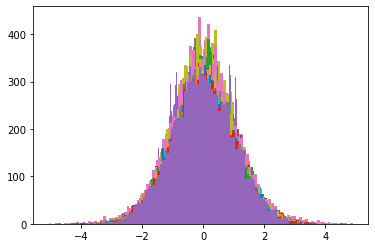

In [1145]:
hub_tables['en'].set_index('reg', drop=False, inplace=True)
from time import sleep
for i, r in hub_tables['en'].iterrows():
    ts = r['t_shuffled']
    
    plt.hist(ts, bins=100)
#     sleep(30)

In [1130]:
hub_tables['en']

,reg,ppc_successful,ppc_unsuccessful,ppc_differences,sub_count,t,t_shuffled,p_fdr,hub
0,L amygdala,"[nan, 0.009311337508569571, 0.0097635162966903...","[nan, 0.010014421049340935, 0.0094328105198447...","[nan, -0.0007030835407713636, 0.00033070577684...",124,3.171178,"[-0.23437310147409945, 0.11068729668672789, 0....",0.001442,True
1,L angular gyrus,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",45,0.976066,"[1.1363478465956318, 0.805206677445889, 0.2953...",0.275149,False
2,L anterior cingulate gyrus,"[nan, nan, nan, nan, nan, 0.011748056506808345...","[nan, nan, nan, nan, nan, 0.01520456115669236,...","[nan, nan, nan, nan, nan, -0.00345650464988401...",76,1.719887,"[1.1563764938492036, -0.737050542119734, -0.96...",0.071655,False
3,L basal forebrain,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,NaN,[],NaN,False
4,L calcarine cortex,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",16,1.946649,"[-0.25903348080138766, -0.6304627453653824, 0....",0.043472,True
...,...,...,...,...,...,...,...,...,...
75,R supramarginal gyrus,"[0.007091661069124275, nan, nan, 0.01955410022...","[0.006252589875981721, nan, nan, 0.01700297404...","[0.0008390711931425534, nan, nan, 0.0025511261...",123,0.445876,"[-1.3229687520706745, 0.2424546096310255, 0.14...",0.537364,False
76,R temporal pole,"[nan, 0.012232361013857449, nan, nan, nan, nan...","[nan, 0.013934540514819238, nan, nan, nan, nan...","[nan, -0.0017021795009617893, nan, nan, nan, n...",69,0.909437,"[0.027763508187448896, 1.6138169707840297, 0.7...",0.303674,False
77,R thalamus,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",3,NaN,[],NaN,False
78,R transverse temporal gyrus,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",20,-1.225856,"[-1.3913212869724476, 0.913389239812065, 1.625...",0.184642,False


In [ ]:
en_pop_symx = xr.open_dataarray(

### Network map visualization

## MTL and hippocampus

In [159]:
display_all()
regions_lobes_df=pd.read_csv(join(root_dir, 'regions_lobes_df.csv')).set_index('region')
regions_lobes_df

,lobe
region,
amygdala,MTL
angular gyrus,parietal
anterior cingulate gyrus,PFC
basal forebrain,NaN
calcarine cortex,NaN
caudate nucleus,NaN
cuneus,NaN
frontal pole,PFC
frontoparietal operculum,NaN


In [164]:
regions_lobes_df.query('lobe == "MTL"')

,lobe
region,
amygdala,MTL
hippocampus,MTL
parahippocampal gyrus,MTL


In [166]:
regions_lobes_df.query('lobe == "LTC"')

,lobe
region,
inferior temporal gyrus,LTC
middle temporal gyrus,LTC
superior temporal gyrus,LTC
temporal pole,LTC
transverse temporal gyrus,LTC


In [167]:
regions_lobes_df.query('lobe == "PFC"')

,lobe
region,
anterior cingulate gyrus,PFC
frontal pole,PFC
inferior frontal gyrus,PFC
medial frontal cortex,PFC
middle frontal gyrus,PFC
orbitofrontal cortex,PFC
rectal gyrus,PFC
superior frontal gyrus,PFC


In [168]:
regions_lobes_df.query('lobe == "parietal"')

,lobe
region,
angular gyrus,parietal
inferior parietal lobule,parietal
posterior cingulate gyrus,parietal
precuneus,parietal
superior parietal lobule,parietal
supramarginal gyrus,parietal


In [169]:
regions_lobes_df[pd.isna(regions_lobes_df['lobe'])]

,lobe
region,
basal forebrain,NaN
calcarine cortex,NaN
caudate nucleus,NaN
cuneus,NaN
frontoparietal operculum,NaN
fusiform gyrus,NaN
insula,NaN
lateral occipital cortex,NaN
lentiform nucleus,NaN


### Analyze lobes

In [172]:
regions_to_lobes = {}
for lobe in ['MTL', 'LTC', 'PFC', 'parietal']:
    regions_to_lobes[lobe] = regions_lobes_df.query('lobe == @lobe').index.values

In [173]:
for k in regions_to_lobes.keys():
    regions_to_lobes[k] = [i + ' ' + j for i in ['L', 'R'] for j in regions_to_lobes[k]]

In [174]:
regions_to_lobes

{'MTL': ['L amygdala',
  'L hippocampus',
  'L parahippocampal gyrus',
  'R amygdala',
  'R hippocampus',
  'R parahippocampal gyrus'],
 'LTC': ['L inferior temporal gyrus',
  'L middle temporal gyrus',
  'L superior temporal gyrus',
  'L temporal pole',
  'L transverse temporal gyrus',
  'R inferior temporal gyrus',
  'R middle temporal gyrus',
  'R superior temporal gyrus',
  'R temporal pole',
  'R transverse temporal gyrus'],
 'PFC': ['L anterior cingulate gyrus',
  'L frontal pole',
  'L inferior frontal gyrus',
  'L medial frontal cortex',
  'L middle frontal gyrus',
  'L orbitofrontal cortex',
  'L rectal gyrus',
  'L superior frontal gyrus',
  'R anterior cingulate gyrus',
  'R frontal pole',
  'R inferior frontal gyrus',
  'R medial frontal cortex',
  'R middle frontal gyrus',
  'R orbitofrontal cortex',
  'R rectal gyrus',
  'R superior frontal gyrus'],
 'parietal': ['L angular gyrus',
  'L inferior parietal lobule',
  'L posterior cingulate gyrus',
  'L precuneus',
  'L supe

In [177]:
for k in regions_to_lobes.keys():
    assert len(regions_to_lobes[k]) == 2*len(regions_lobes_df.query('lobe == @k'))
print('Check passed.')

Check passed.


In [188]:
lobes = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    lobes_df = pd.DataFrame()
    
    for lobe in ['LTC', 'PFC', 'parietal']:
        MTL_mx = mx.sel(reg1 = regions_to_lobes['MTL'], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes[lobe]]).mean('reg2').mean('reg1').data
        lobe2_mx = mx.sel(reg1 = regions_to_lobes[lobe], reg2 = [reg for reg in mx.reg2.values if reg not in regions_to_lobes['MTL']]).mean('reg2').mean('reg1').data
        where_finite = np.isfinite(MTL_mx) & np.isfinite(lobe2_mx)
        MTL_mx = MTL_mx[where_finite]
        lobe2_mx = lobe2_mx[where_finite]
        
        t, p = scipy.stats.ttest_rel(MTL_mx, lobe2_mx, alternative='two-sided')
        lobes_df.loc[lobe, 'dof'] = len(MTL_mx) - 1
        lobes_df.loc[lobe, 't'] = t
        lobes_df.loc[lobe, 'p'] = p
        
    lobes[beh] = lobes_df

In [189]:
from statsmodels.stats import multitest

In [190]:
for beh in ['en', 'rm', 'ri']: lobes[beh]['p_fwe'] = multitest.multipletests(pvals=lobes[beh]['p'].values,method='holm')[1]

In [191]:
lobes['en']

,dof,t,p,p_fwe
LTC,295.0,-1.412917,0.158734,0.476203
PFC,263.0,0.870085,0.385047,0.770095
parietal,242.0,0.776979,0.437930,0.770095


In [192]:
lobes['rm']

,dof,t,p,p_fwe
LTC,295.0,0.849233,0.396440,0.457216
PFC,263.0,1.206762,0.228608,0.457216
parietal,242.0,3.769381,0.000206,0.000617


In [193]:
lobes['ri']

,dof,t,p,p_fwe
LTC,132.0,-0.154991,0.877065,1.000000
PFC,117.0,1.015467,0.311979,0.935936
parietal,106.0,0.310911,0.756479,1.000000


In [178]:
mx_fname = os.path.join(root_dir, 'en_pop_symx.nc')
mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq')
mx = mx.sel(success=1) - mx.sel(success=0)

In [183]:
lobe1 = ['L hippocampus', 'R hippocampus', 'L amygdala', 'R amygdala', 'L parahippocampal gyrus', 'R parahippocampal gyrus']
lobe1_C = [reg for reg in get_region_information('region_labels') if reg not in lobe1]
assert len(get_region_information('region_labels')) == len(lobe1) + len(lobe1_C)
assert len(np.intersect1d(lobe1, lobe1_C)) == 0

lobe2 = ['L inferior temporal gyrus', 'L middle temporal gyrus', 'L superior temporal gyrus', 'L transverse temporal gyrus', 'L temporal pole', 'R inferior temporal gyrus', 'R middle temporal gyrus', 'R superior temporal gyrus', 'R transverse temporal gyrus', 'R temporal pole']
lobe2_C = [reg for reg in get_region_information('region_labels') if reg not in lobe2]
assert len(get_region_information('region_labels')) == len(lobe2) + len(lobe2_C)
assert len(np.intersect1d(lobe2, lobe2_C)) == 0

print('Check passed.')

Check passed.


In [185]:
MTL_mean_hubness = mx.sel(reg1 = lobe1, reg2 = lobe2_C).mean('reg2').mean('reg1').data
LTC_mean_hubness = mx.sel(reg1 = lobe2, reg2 = lobe1_C).mean('reg2').mean('reg1').data
where_finite = np.isfinite(MTL_mean_hubness) & np.isfinite(LTC_mean_hubness)
MTL_mean_hubness = MTL_mean_hubness[where_finite]
LTC_mean_hubness = LTC_mean_hubness[where_finite]

In [196]:
assert scipy.stats.ttest_rel(MTL_mean_hubness, LTC_mean_hubness)[0] == lobes['en'].loc['LTC', 't']
assert len(MTL_mean_hubness) == len(LTC_mean_hubness) == lobes['en'].loc['LTC', 'dof'] + 1
print('Check passed.')

Check passed.


In [211]:
p_values = lobes['en']['p'].values
sorting_order = np.argsort(p_values)
p_values_sorted = p_values[sorting_order]
p_values_corrected = lobes['en']['p_fwe'].values[sorting_order]
m = len(p_values)
alpha = 0.05
adjusted_p_tracker = []
for k, p_value in enumerate(p_values_sorted):
    j = k+1
    adjusted_p_tracker.append((m-j+1)*p_value)
    assert np.max(adjusted_p_tracker[:j]) == p_values_corrected[k]
print('Check passed.')

Check passed.


### Hippocampus and PFC

In [222]:
hippocampus_PFC = pd.Series({})
for beh in ['en', 'rm', 'ri']:
    hippocampus_PFC_df = pd.DataFrame()
    mx = xr.open_dataarray(join(root_dir, f'{beh}_pop_symx.nc')).mean('epoch').mean('freq')
    mx = mx.sel(success=1) - mx.sel(success=0)
    MFG = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L middle frontal gyrus', 'R middle frontal gyrus']).mean('reg2').mean('reg1').data)
    mPFC = finitize(mx.sel(reg1 = ['L hippocampus', 'R hippocampus'], reg2 = ['L medial frontal cortex', 'R medial frontal cortex',
                                                                     'L anterior cingulate gyrus', 'R anterior cingulate gyrus']).mean('reg2').mean('reg1').data)
    hippocampus_PFC_df.loc['dlPFC', 'dof'] = len(MFG) - 1
    hippocampus_PFC_df.loc['mPFC', 'dof'] = len(mPFC) - 1

    hippocampus_PFC_df.loc['dlPFC', ['t', 'p']] = scipy.stats.ttest_1samp(MFG, popmean=0)[:]
    hippocampus_PFC_df.loc['mPFC', ['t', 'p']] = scipy.stats.ttest_1samp(mPFC, popmean=0)[:]
    hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p_fwe'] = multitest.multipletests(pvals=hippocampus_PFC_df.loc[['dlPFC', 'mPFC'], 'p'].values, method='holm')[1]
    hippocampus_PFC[beh] = hippocampus_PFC_df

In [223]:
hippocampus_PFC['en']

,dof,t,p,p_fwe
dlPFC,191.0,0.188965,0.850321,0.850321
mPFC,92.0,2.562512,0.012016,0.024032


In [224]:
hippocampus_PFC['rm']

,dof,t,p,p_fwe
dlPFC,191.0,0.895630,0.371578,0.371578
mPFC,92.0,2.082535,0.040069,0.080138


In [225]:
hippocampus_PFC['ri']

,dof,t,p,p_fwe
dlPFC,81.0,0.321069,0.748985,1.0
mPFC,34.0,0.641289,0.525635,1.0


In [226]:
mx_fname = os.path.join(root_dir, 'en_pop_symx.nc')
mx = xr.open_dataarray(mx_fname).mean('epoch').mean('freq')
mx = mx.sel(success=1) - mx.sel(success=0)

In [227]:
HPC_regions = ['L hippocampus', 'R hippocampus']
dlPFC_regions = ['L middle frontal gyrus', 'R middle frontal gyrus']
mPFC_regions = ['L anterior cingulate gyrus', 'R anterior cingulate gyrus', 'L medial frontal cortex', 'R medial frontal cortex']

In [233]:
mx_dlPFC = finitize(mx.sel(reg1 = HPC_regions, reg2 = dlPFC_regions).mean('reg2').mean('reg1').data)
mx_mPFC = finitize(mx.sel(reg1 = HPC_regions, reg2 = mPFC_regions).mean('reg2').mean('reg1').data)

In [234]:
assert scipy.stats.ttest_1samp(mx_dlPFC, 0)[0] == hippocampus_PFC['en'].loc['dlPFC', 't']
assert len(mx_dlPFC) == hippocampus_PFC['en'].loc['dlPFC', 'dof'] + 1
assert scipy.stats.ttest_1samp(mx_mPFC, 0)[0] == hippocampus_PFC['en'].loc['mPFC', 't']
assert len(mx_mPFC) == hippocampus_PFC['en'].loc['mPFC', 'dof'] + 1
print('Check passed.')

Check passed.


In [237]:
p_values_sorted

array([0.01201582, 0.85032077])

In [240]:
p_values = hippocampus_PFC['en']['p'].values
sorting_order = np.argsort(p_values)
p_values_sorted = p_values[sorting_order]
p_values_corrected = hippocampus_PFC['en']['p_fwe'].values[sorting_order]
m = len(p_values)
alpha = 0.05
adjusted_p_tracker = []
for k, p_value in enumerate(p_values_sorted):
    j = k+1
    adjusted_p_tracker.append((m-j+1)*p_value)
    assert np.max(adjusted_p_tracker[:j]) == p_values_corrected[k]
print('Check passed.')

Check passed.


## Encoding-retrieval correlation

In [393]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error evs_data_source  \
sub    exp sess loc mon                                                    
R1001P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1002P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1003P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   

                         localization  long_distance_pairs_count  \
sub    exp sess loc mon                                            
R1001P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1002P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1003P FR1 0    0   0               0                          0   

                         mat_pairs_available  no_channels  \
sub    exp sess loc mon                                     
R1001P FR1 0    0   0                      1           72   
           1    0   0                      1           72   
R1002P FR1 0    0   0                      1           58   
           1    0   0                      1           58   
R1003P FR1 0    0   0                      1          114   

                         nonempty_regionalizations_count  pairs  pairs_count  \
sub    exp sess loc mon                                                        
R1001P FR1 0    0   0                                 72   True           72   
           1    0   0                                 72   True           72   
R1002P FR1 0    0   0                                 58   True           58   
           1    0   0                                 58   True           58   
R1003P FR1 0    0   0                                114   True          114   

                        pairs_data_source  phase  regionalizations  \
sub    exp sess loc mon                                              
R1001P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1002P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1003P FR1 0    0   0          cmlreaders   True              True   

                         regionalizations_count     sr  sr_present  include  \
sub    exp sess loc mon                                                       
R1001P FR1 0    0   0                        72  500.0        True     True   
           1    0   0                        72  500.0        True     True   
R1002P FR1 0    0   0                        58  500.0        True     True   
           1    0   0                        58  500.0        True     True   
R1003P FR1 0    0   0                       114  500.0        True     True   

                         en_events  en_all_events  rm_events  ri_events  \
sub    exp sess loc mon                                                   
R1001P FR1 0    0   0         True           True       True       True   
           1    0   0         True           True       True       True   
R1002P FR1 0    0   0         True           True       True      False   
           1    0   0         True           True       True  

In [394]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

### Event splitting and matrix computations

In [97]:
sess_idx = 0
beh = 'rm'
beh_split = f'{beh}_split' # value must equal either 'rm_split' or 'ri_split'
# half = 'a' # value must equal either 'a' or 'b'

dfrow = sess_list_df.iloc[sess_idx]
events = load_events(dfrow, beh).sort_values(['mstime', 'eegoffset'])
split_events_a_path = join(root_dir, beh_split, 'a', 'events', f'{ftag(dfrow)}_{beh}_events_split_a.json')
split_events_a = pd.read_json(split_events_a_path)
split_events_b_path = join(root_dir, beh_split, 'b', 'events', f'{ftag(dfrow)}_{beh}_events_split_b.json')
split_events_b = pd.read_json(split_events_b_path)

In [98]:
split_events_joined = pd.concat([split_events_a, split_events_b]).sort_values(['mstime', 'eegoffset']).drop('pair_idx', axis=1)
assert split_events_joined.equals(events)

In [99]:
match_cols = ['mstime', 'eegoffset', 'type']
events = load_events(dfrow, beh)
events_to_match = events[match_cols]
split_events_a_to_match = split_events_a[match_cols]
split_events_b_to_match = split_events_b[match_cols]
for i in np.arange(len(events_to_match)//2):
    event_pair = events_to_match.iloc[2*i:(2*i+2)]
    together = False
    assert ( event_pair.isin(split_events_a_to_match).all().all() | event_pair.isin(split_events_b_to_match).all().all())
print('Checks passed.')

Checks passed.


In [100]:
split_events_a.attrs['mask'] = (split_events_a['type'] == 'REC_WORD').values
split_events_a.attrs['beh'] = beh

In [101]:
iElec1, iElec2 = 5, 10
iFreq = 0
iEpoch = 0
iSuccess = 0

In [102]:
eeg, mask = get_eeg(dfrow, split_events_a, -1000, 0)
eeg = mirror_buffer(eeg, 1000)
eeg = eeg.resampled(250)
eeg = notch_filter(eeg, dfrow['sub'])
phase = get_phase(eeg, np.arange(3, 9))
phase = clip_buffer(phase, 250)
phase_diff = phase.isel(channel = iElec1) - phase.isel(channel = iElec2)
phase_diff = timebin_phase_timeseries(phase_diff.data, 250)
phase_diff = phase_diff[:, iFreq, iEpoch]
ppc_value = ppc(phase_diff[mask])

CPP total time wavelet loop:  0.5323333740234375


In [103]:
reference_elsymx_fname = join(root_dir, 'rm_split', 'a', 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
reference_elsymx = npl(reference_elsymx_fname)
rtol = 1e-5
atol = 1e-8
assert np.isclose(ppc_value, reference_elsymx[iElec1, iElec2, iFreq, iEpoch, iSuccess], rtol=rtol, atol=atol)
print('Check passed.')

Check passed.


### Correlation computation and aggregation

In [420]:
beh1, beh2 = 'en', 'rm'
all_rs = []
for sub in sublist: # Iterate through all subjects
    
    this_sub_sesslist = sess_list_df.query('sub == @sub') # Get the list of all sessions 
    this_sub_rs = [] # Initialize list to hold this subject's correlation values
    for iSess, rSess in this_sub_sesslist.iterrows(): # Iterate through all this subject's sessions
        
        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
        pairs = get_pairs(dfrow)
        mx1_fname = os.path.join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        mx2_fname = os.path.join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy')
        
        mx1 = npl(mx1_fname)
        mx2 = npl(mx2_fname)
        assert not np.allclose(mx1, mx2, rtol=1e-5, atol=1e-8) # Make sure taht we did not accidentally mix up mx1 and mx2
        
        for mx in [mx1, mx2]:
#             assert mx.shape == (len(pairs), len(pairs), 6, 5, 2)
            assert np.nanmax(mx) <= 1, f'{np.max(mx)}'
            assert np.nanmin(mx) >= -1
            assert np.allclose(mx, np.swapaxes(mx, 0, 1), equal_nan=True)
            finite_count = count_finite(mx) # Get fraction of electrode synchrony matrix that is not a nan value
            assert finite_count > 0.8, f'{tuple(dfrow)}: {finite_count}, {len(pairs)}' # Check that the fraction of electrode synchrony matrix is above an arbitrary threshold, 0.9
            assert not np.any(np.isfinite(np.diagonal(mx))) 
            
        assert np.allclose(np.isfinite(mx1), np.isfinite(mx2))
        
#         for mx in [mx1, mx2]:
#             mx = np.subtract(mx[..., 0], mx[..., 1]) # Calculate ΔPPC by subtracting unsuccessful PPC values from PPC successful values
# #             assert mx.shape == (len(pairs), len(pairs), 6, 5) # Check that the electrode synchrony matrix has lost the last successful/unsuccessful dimension after subtraction

#             mx = np.nanmean(mx, axis=-1) # Average electrode synchrony matrix over time epochs
# #             assert mx.shape == (len(pairs), len(pairs), 6) # Check that the electrode synchrony matrix has lost the last time epoch dimension after averaging

#             mx = np.nanmean(mx, axis=-1) # Average electrode synchrony matrix over theta frequencies
# #             assert mx.shape == (len(pairs), len(pairs)) # Check that the electrode synchrony matrix has lost the last frequency dimension after averaging

#             mx = np.nanmean(mx, axis=-1) # Average electrode synchrony matrix over contact 2 to obtain contact-level hubness scores
# #             assert len(mx) == len(pairs), f'{mx.shape}' # Check that the electrode synchrony matrix has lost the last contact dimension after averaging

#             assert np.all(np.isfinite(mx)) # Check that the hubness matrix has no nan values
#             assert len(mx) >= 10, 'length of electrode synchrony hubness matrix is less than 10' # Check that there at least 10 contacts for the correlation 

        mx1 = mx1[..., 0]-mx1[..., 1]
        mx1 = np.nanmean(np.nanmean(np.nanmean(mx1, axis=-1), axis=-1), axis=-1)
        mx2 = mx2[..., 0]-mx2[..., 1]
        mx2 = np.nanmean(np.nanmean(np.nanmean(mx2, axis=-1), axis=-1), axis=-1)
        
        where_finite = np.isfinite(mx1) & np.isfinite(mx2)
        assert np.allclose(where_finite, np.isfinite(mx1))
        assert np.allclose(where_finite, np.isfinite(mx2))
        mx1 = mx1[where_finite]
        mx2 = mx2[where_finite]
        assert not np.allclose(mx1, mx2, rtol=1e-5, atol=1e-8) # Make sure that we did not accidentally mix up mx1 and mx2
        
        r = scipy.stats.pearsonr(mx1, mx2)[0]
        assert -1 <= r <= 1
        this_sub_rs.append(r)
        
    assert len(this_sub_rs) == len(this_sub_sesslist)
    this_sub_mean_r = np.mean(this_sub_rs)
    all_rs.append(this_sub_mean_r)
    
all_rs = np.asarray(all_rs)

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: Mean of empty slice


In [421]:
t, p = scipy.stats.ttest_1samp(all_rs,0)
print(f't_{len(all_rs)-1} = {t}, p = {p}')

t_377 = 5.489211992850639, p = 7.428226963553986e-08


In [423]:
np.mean(all_rs)

0.03996501261980553

In [417]:
def apply_spearman_brown_correction(r): return (2*r)/(1+r)

def compute_intercontrast_correlations(beh1, beh2):
    
    if ('ri' in beh1) or ('ri' in beh2): sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('(include == True) & (ri_events == True)')
    else: sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True')
    
    sub_list = sess_list_df['sub'].unique()
    
    sub_corrs = []
    
    for iSub, sub in enumerate(sub_list):
        
        sess_corrs = []
        
        for iSess, rSess in sess_list_df.query('sub == @sub').iterrows():
            
            dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']]
            beh1_mx = npl(join(root_dir, beh1, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
            beh2_mx = npl(join(root_dir, beh2, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy'))
    
            beh1_mx = beh1_mx[..., 0] - beh1_mx[..., 1]
            beh2_mx = beh2_mx[..., 0] - beh2_mx[..., 1]
            
            beh1_mx = np.nanmean(np.nanmean(np.nanmean(beh1_mx, axis=-1), axis=-1), axis=-1)
            beh2_mx = np.nanmean(np.nanmean(np.nanmean(beh2_mx, axis=-1), axis=-1), axis=-1)
            
            r = scipy.stats.pearsonr(beh1_mx, beh2_mx)[0]
            if (beh1, beh2) in [('rm_split/a', 'rm_split/b'), ('rm_split/a', 'rm_split/b')]: 
                r = apply_spearman_brown_correction(r)

            sess_corrs.append(r)
            
        sub_corrs.append(np.mean(sess_corrs))
        
    return np.asarray(sub_corrs)
        

In [418]:
en_rm_sub_corrs = compute_intercontrast_correlations('en', 'rm')
print_ttest_1samp(en_rm_sub_corrs, header='en / rm correlation')

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


---------en / rm correlation---------
Statistically Significant (p < 0.05)
t_377 = 5.49, p = 7.43e-08, Mean: 0.04 ± 0.00728


(5.489211992850639, 7.428226963553986e-08)

In [416]:
np.mean(all_rs)

0.3778708008745583

In [402]:
count_finite(mx)

(0.9645061728395061,)

In [400]:
count_finite?

Signature: count_finite(x)
Docstring: <no docstring>
File:      ~/ConnectivityProject/matrix_operations.py
Type:      function


## Power-synchrony correlation

In [426]:
sess_list_df = pd.read_json(join(root_dir, 'sess_list_df.json')).query('include == True').set_index(['sub', 'exp', 'sess', 'loc', 'mon'], drop=False)
print(f'Length of sess_list_df: {len(sess_list_df)}')
sess_list_df.head()

Length of sess_list_df: 980


sub  exp  sess  loc  mon atlas contacts_source  \
sub    exp sess loc mon                                                      
R1001P FR1 0    0   0    R1001P  FR1     0    0    0   avg        contacts   
           1    0   0    R1001P  FR1     1    0    0   avg        contacts   
R1002P FR1 0    0   0    R1002P  FR1     0    0    0   avg        contacts   
           1    0   0    R1002P  FR1     1    0    0   avg        contacts   
R1003P FR1 0    0   0    R1003P  FR1     0    0    0   avg        contacts   

                          eeg eeg_data_source  eeg_error evs_data_source  \
sub    exp sess loc mon                                                    
R1001P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1002P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   
           1    0   0    True      cmlreaders        NaN      cmlreaders   
R1003P FR1 0    0   0    True      cmlreaders        NaN      cmlreaders   

                         localization  long_distance_pairs_count  \
sub    exp sess loc mon                                            
R1001P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1002P FR1 0    0   0               0                          0   
           1    0   0               0                          0   
R1003P FR1 0    0   0               0                          0   

                         mat_pairs_available  no_channels  \
sub    exp sess loc mon                                     
R1001P FR1 0    0   0                      1           72   
           1    0   0                      1           72   
R1002P FR1 0    0   0                      1           58   
           1    0   0                      1           58   
R1003P FR1 0    0   0                      1          114   

                         nonempty_regionalizations_count  pairs  pairs_count  \
sub    exp sess loc mon                                                        
R1001P FR1 0    0   0                                 72   True           72   
           1    0   0                                 72   True           72   
R1002P FR1 0    0   0                                 58   True           58   
           1    0   0                                 58   True           58   
R1003P FR1 0    0   0                                114   True          114   

                        pairs_data_source  phase  regionalizations  \
sub    exp sess loc mon                                              
R1001P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1002P FR1 0    0   0          cmlreaders   True              True   
           1    0   0          cmlreaders   True              True   
R1003P FR1 0    0   0          cmlreaders   True              True   

                         regionalizations_count     sr  sr_present  include  \
sub    exp sess loc mon                                                       
R1001P FR1 0    0   0                        72  500.0        True     True   
           1    0   0                        72  500.0        True     True   
R1002P FR1 0    0   0                        58  500.0        True     True   
           1    0   0                        58  500.0        True     True   
R1003P FR1 0    0   0                       114  500.0        True     True   

                         en_events  en_all_events  rm_events  ri_events  \
sub    exp sess loc mon                                                   
R1001P FR1 0    0   0         True           True       True       True   
           1    0   0         True           True       True       True   
R1002P FR1 0    0   0         True           True       True      False   
           1    0   0         True           True       True  

In [427]:
sublist = sess_list_df['sub'].unique() # Get list of unique subject codes
print(f'There are {len(sublist)} analyzed subjects.')
print(sublist) # Print the list of unique subject codes

There are 378 analyzed subjects.
['R1001P' 'R1002P' 'R1003P' 'R1006P' 'R1010J' 'R1013E' 'R1016M' 'R1018P'
 'R1020J' 'R1021D' 'R1022J' 'R1024E' 'R1026D' 'R1028M' 'R1030J' 'R1031M'
 'R1032D' 'R1033D' 'R1035M' 'R1036M' 'R1039M' 'R1042M' 'R1045E' 'R1048E'
 'R1050M' 'R1051J' 'R1052E' 'R1053M' 'R1054J' 'R1056M' 'R1060M' 'R1061T'
 'R1062J' 'R1063C' 'R1065J' 'R1066P' 'R1067P' 'R1068J' 'R1069M' 'R1070T'
 'R1074M' 'R1075J' 'R1076D' 'R1077T' 'R1080E' 'R1083J' 'R1084T' 'R1089P'
 'R1092J' 'R1093J' 'R1094T' 'R1096E' 'R1098D' 'R1101T' 'R1102P' 'R1104D'
 'R1105E' 'R1106M' 'R1107J' 'R1108J' 'R1111M' 'R1112M' 'R1113T' 'R1114C'
 'R1115T' 'R1118N' 'R1120E' 'R1121M' 'R1122E' 'R1123C' 'R1124J' 'R1125T'
 'R1127P' 'R1128E' 'R1129D' 'R1130M' 'R1131M' 'R1134T' 'R1135E' 'R1136N'
 'R1137E' 'R1138T' 'R1141T' 'R1144E' 'R1145J' 'R1146E' 'R1147P' 'R1148P'
 'R1149N' 'R1150J' 'R1151E' 'R1153T' 'R1154D' 'R1156D' 'R1157C' 'R1161E'
 'R1162N' 'R1163T' 'R1164E' 'R1166D' 'R1167M' 'R1168T' 'R1169P' 'R1170J'
 'R1172E' 'R1173J'

In [433]:
beh = 'en' # Set behavioral contrast (encoding)
all_rs = []
for sub in sublist: # Iterate through all subjects
    
    this_sub_sesslist = sess_list_df.query('sub == @sub') # Get list of sessions that this subject (i.e., the subject on the current for-loop iteration) completed
    this_sub_session_count = len(this_sub_sesslist)
    this_sub_rs = [] # Initialize list to contain the correlation values calculated for each of this subject's sessions
    for iSess, rSess in this_sub_sesslist.iterrows(): # Iterate through all this subject's sessions
        
        dfrow = rSess[['sub', 'exp', 'sess', 'loc', 'mon']] # Get dfrow that labels this session 
        pairs = get_pairs(dfrow)
        elsymx_fname = os.path.join(root_dir, beh, 'elsymxs', f'{ftag(dfrow)}_elsymx.npy') # Set electrode synchrony matrix file name
        elpomx_fname = os.path.join(root_dir, beh, 'elpomxs', 'theta', f'{ftag(dfrow)}_elpomxd.npy') # Set electrode power change matrix file name
        assert os.path.exists(elsymx_fname), 'elsymx path does not exist' # Verify that electrode synchrony matrix file path exists
        assert os.path.exists(elpomx_fname), 'elpomx path does not exist' # Verify that electrode power change matrix file path exists
        
        elsymx = np.load(elsymx_fname, allow_pickle=True) # Load electrode synchrony matrix into memory
#         assert elsymx.shape == (len(pairs), len(pairs), 6, 5, 2) # Check that elsymx is the right shape (number of pairs x number of pairs x frequencies x epochs x successful/unsuccessful)
        assert np.nanmax(elsymx) <= 1 # Check that PPC values in electrode synchrony matrix are bounded above by 1
        assert np.nanmin(elsymx) >= -1 # Check that PPC values in electrode synchrony matrix are bounded below by -1
        assert np.allclose(elsymx, np.swapaxes(elsymx, 0, 1), equal_nan=True) # Check that electrode synchrony matrix is symmetric
        finite_count = count_finite(elsymx), # Get fraction of electrode synchrony matrix that is not a nan value
#         assert finite_count > 0.8 # Check that the fraction of electrode synchrony matrix is above an arbitrary threshold, 0.9
        assert not np.any(np.isfinite(np.diagonal(elsymx))) # Check that the diagonal of the electrode synchrony matrix consists of nan values
        
        elsymx = np.subtract(elsymx[..., 0], elsymx[..., 1]) # Calculate ΔPPC by subtracting unsuccessful PPC values from PPC successful values
#         assert elsymx.shape == (len(pairs), len(pairs), 6, 5) # Check that the electrode synchrony matrix has lost the last successful/unsuccessful dimension after subtraction
        
        elsymx = np.nanmean(elsymx, axis=-1) # Average electrode synchrony matrix over time epochs
#         assert elsymx.shape == (len(pairs), len(pairs), 6) # Check that the electrode synchrony matrix has lost the last time epoch dimension after averaging
        
        elsymx = np.nanmean(elsymx, axis=-1) # Average electrode synchrony matrix over theta frequencies
#         assert elsymx.shape == (len(pairs), len(pairs)) # Check that the electrode synchrony matrix has lost the last frequency dimension after averaging
        
        elsymx = np.nanmean(elsymx, axis=-1) # Average electrode synchrony matrix over contact 2 to obtain contact-level hubness scores
#         assert elsymx.shape == (len(pairs)) # Check that the electrode synchrony matrix has lost the last contact dimension after averaging
        
        assert np.all(np.isfinite(elsymx)) # Check that the hubness matrix has no nan values
        assert len(elsymx) >= 10, 'length of electrode synchrony hubness matrix is less than 10' # Check that there at least 10 contacts for the correlation 
        
        elpomx = np.load(elpomx_fname, allow_pickle=True) # Load electrode power change matrix into memory
#         assert elpomx.shape == (len(pairs), 6, 5) # Check that the electrode power change matrix is the right shape (number of pairs x frequencies x epochs)
        
        elpomx = np.nanmean(elpomx, axis=-1)
#         assert elpomx.shape == (len(pairs), 6)
        
        elpomx = np.nanmean(elpomx, axis=-1)
#         assert elpomx.shape == (len(pairs))
        
        where_finite = np.isfinite(elsymx) & np.isfinite(elpomx)
        elsymx = elsymx[where_finite]
        elpomx = elpomx[where_finite]
        
        r = scipy.stats.pearsonr(elsymx, elpomx)[0]
        assert -1 <= r <= 1
        
        this_sub_rs.append(r)
    
    assert len(this_sub_rs) == this_sub_session_count
    
    this_sub_mean_r = np.mean(this_sub_rs)
    all_rs.append(this_sub_mean_r)
        
all_rs = np.asarray(all_rs)

/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: Mean of empty slice
/usr/global/Anaconda/2019-10/envs/cml37/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice


In [435]:
t, p = scipy.stats.ttest_1samp(all_rs,0)
print(f't_{len(all_rs)-1} = {t}, p = {p}')

t_377 = 46.610181926751785, p = 1.483587956891569e-158


In [436]:
np.mean(all_rs)

0.28113625580953294